# Function Regression

# Import

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam, SGD
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

import numpy as np
import random
import math

from sklearn.manifold import TSNE
import time

import altair as alt
alt.data_transformers.disable_max_rows()
import pandas as pd
GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

random.seed(666)

Using cpu


# CFF Network

In [26]:
class CFF(torch.nn.Module):
    def __init__(self,
                 x_in, x_lr,
                 y_in, y_lr, d_lr,
                 hid_dims,# 500, 300, 300
                 d_loss_func=torch.nn.CrossEntropyLoss(),
                 enc_ABC=[1,1,1]):
        super(CFF, self).__init__()
        self.x_net = torch.nn.Sequential( torch.nn.Linear(x_in, hid_dims[0]) ).to(device) # 784_500
        self.y_net = torch.nn.Sequential( torch.nn.Linear(y_in, hid_dims[0]) ).to(device) # 784_500
        self.d_net = torch.nn.Sequential( torch.nn.Linear(hid_dims[0], y_in) ).to(device) # 500_10
        for i in range(len(hid_dims)-1):
            self.x_net.append( torch.nn.Linear( hid_dims[i], hid_dims[i+1]) ).to(device)
            self.y_net.append( torch.nn.Linear( hid_dims[i], hid_dims[i+1]) ).to(device)
            self.d_net.append( torch.nn.Linear( hid_dims[i+1], y_in) ).to(device)
        self.relu = torch.nn.ReLU()
        # optimizers, loss
        self.x_opt = Adam(self.x_net.parameters(), lr=x_lr)
        self.y_opt = Adam(self.y_net.parameters(), lr=y_lr)
        self.d_opt = Adam(self.d_net.parameters(), lr=d_lr)
        self.d_loss_func = d_loss_func
        self.A, self.B, self.C = enc_ABC

    def forward(self, x, y_pos, y_neg, layer_ind):
        Zx = self.x_net[layer_ind]( x ) # [60000, 500]
        Zys = self.y_net[layer_ind]( torch.cat([y_neg, y_pos],0) ) # [120000, 500]
        Zy_neg, Zy_pos = Zys[:len(y_neg)], Zys[len(y_pos):] # [60000, 500], [60000, 500]
        pos_sim = F.cosine_similarity(Zx, Zy_pos, dim=1) * self.A
        neg_sim = F.cosine_similarity(Zx, Zy_neg, dim=1) * self.B
        y_neg_similarity = F.cosine_similarity(Zy_neg, Zy_pos, dim=1) * self.C
        loss = (- pos_sim + neg_sim - y_neg_similarity).mean()
        # loss = (- pos_sim + neg_sim).mean()
        self.x_opt.zero_grad()
        self.y_opt.zero_grad()
        loss.backward()
        self.x_opt.step()
        self.y_opt.step()
        return Zx, Zy_pos, Zy_neg, loss.item()

    def d_forward(self, Zx, true_y_pos, layer_ind):
        y_pred = self.d_net[layer_ind]( Zx )
        # loss = self.d_loss_func(y_pred, true_y_pos)
        loss = torch.sqrt(self.d_loss_func(y_pred, true_y_pos))
        self.d_opt.zero_grad()
        loss.backward()
        self.d_opt.step()
        return y_pred, loss.item()

# Create_data()

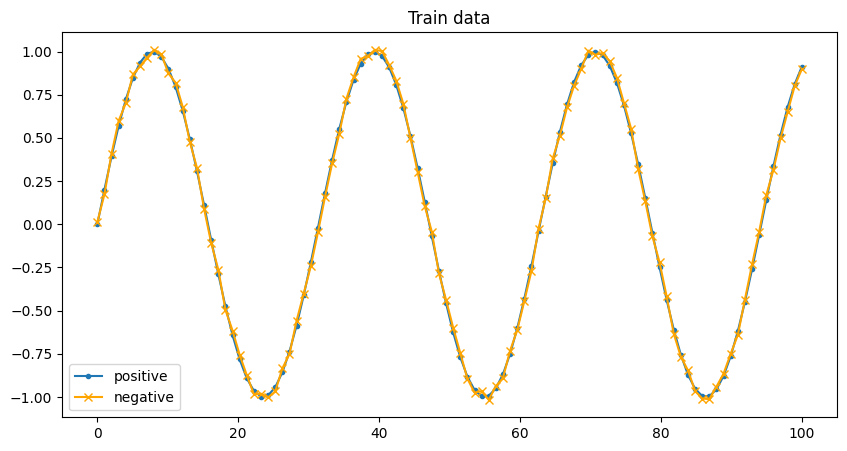

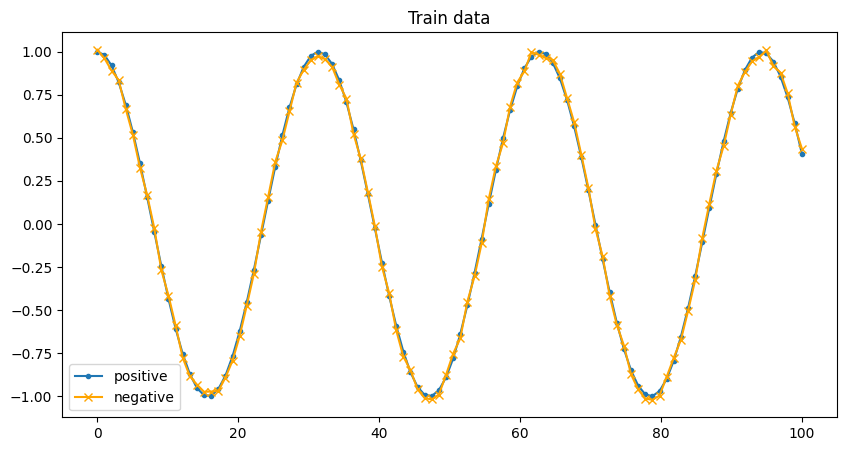

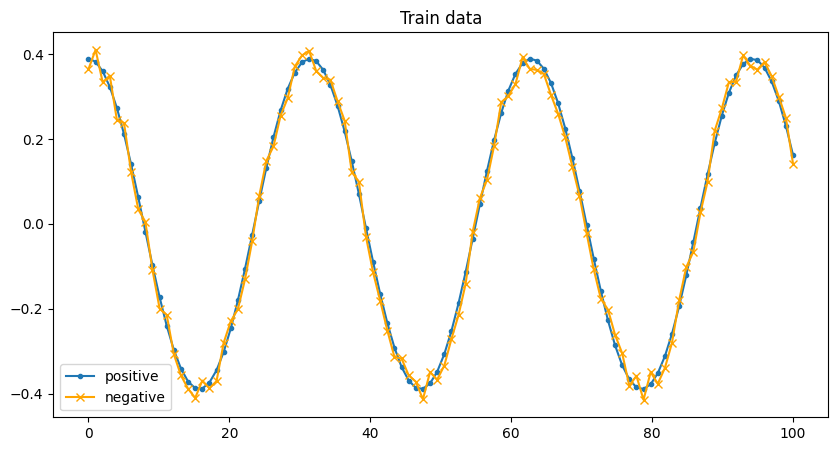

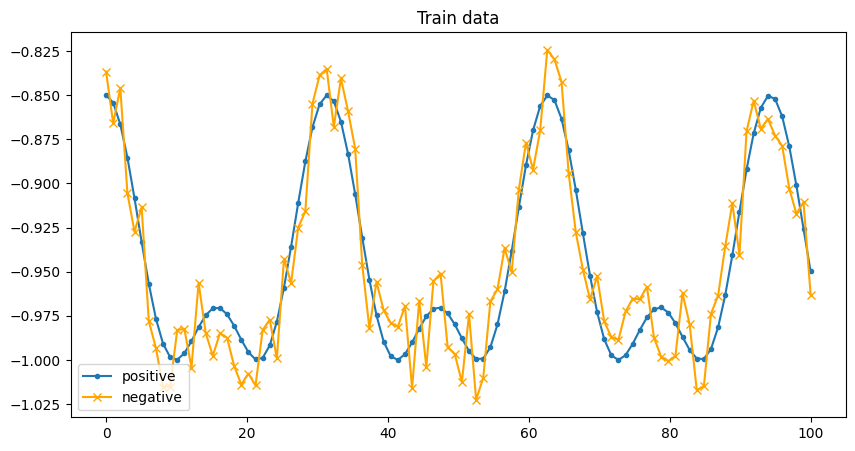

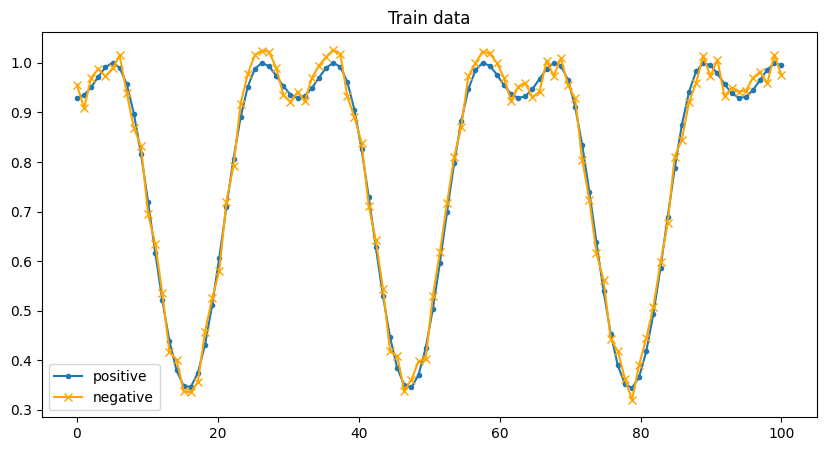

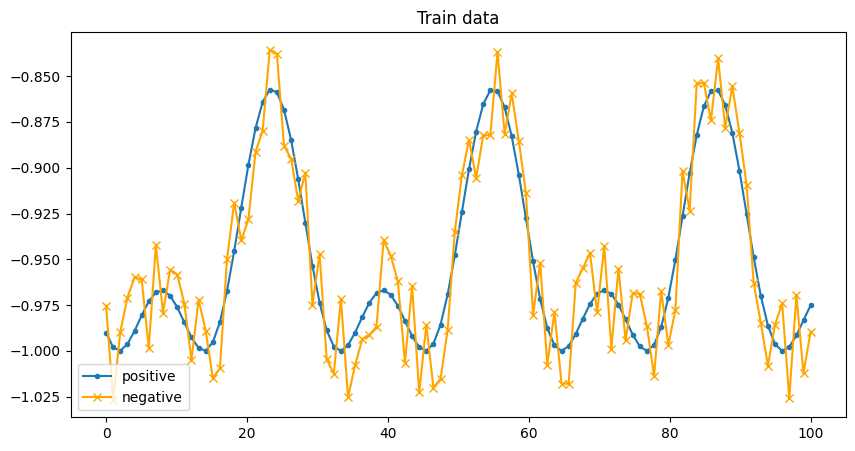

In [71]:
def get_y_neg(y, val_off=[0.3,0.2]):
    y_neg = y.clone()
    for i in range(len(y)):
        r = 1 if random.random() < 0.5 else -1
        y_neg[i] += r*val_off[0] + r*random.random() * val_off[1]
    return y_neg

def create_data(num_data=100, len_data=100, offset=[0.3,0.2], f=lambda x: np.sin(0.2*x), do_plot=False):
    x_data_tr, y_data_tr, y_data_tr_neg = [], [], []
    for i in range(num_data):
        xi = torch.linspace(0.1*i, 0.1*i+100, len_data)
        yi = f(xi)
        yi_neg = get_y_neg(yi, offset)
        x_data_tr.append(xi)
        y_data_tr.append(yi)
        y_data_tr_neg.append(yi_neg)

    x_data_te, y_data_te = [], []
    for i in range(num_data):
        xi = torch.linspace(0.1*i+100, 0.1*i+200, len_data)
        yi = f(xi)
        x_data_te.append(xi)
        y_data_te.append(yi)
    #-------plot-------
    if do_plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        ax.set_title('Train data')
        ax.plot(x_data_tr[0], y_data_tr[0], '.-', label="positive")
        ax.plot(x_data_tr[0], y_data_tr_neg[0], 'x-', label='negative', c='orange')
        ax.legend(loc='lower left')

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        ax.set_title('Data')
        ax.plot(x_data_tr[0], y_data_tr[0], 'x-', label="Train")
        ax.plot(x_data_te[0], y_data_te[0], '.-', label="Expected Extrapolation", c='C0', linewidth=10, alpha=0.5 )
        ax.legend(loc='lower left')
        plt.show()
    return x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te

# for fi in [lambda x: np.sin(0.2*x), lambda x: np.cos(0.2*x), lambda x: np.sin(0.4*np.cos(0.2*x)), lambda x: np.sin(0.4*np.cos(0.2*x)+30), lambda x: np.sin(0.8*np.cos(0.2*x)+20), lambda x: np.cos(0.4*np.sin(0.2*x)+3)]:
#     _, _, _, _, _ = create_data(num_data=100, len_data=100, offset=[0.01,0.02], f=fi, do_plot=True)

# x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100, len_data=100, offset=[0.05, 0.1], f=lambda x: np.sin(0.2*x), do_plot=True)


# (Baseline) BP Network


In [21]:
# Baseline back-propagation based model
class BPNet(torch.nn.Module):
    def __init__(self, dims, b=120, epoch=50, loss_func=F.cross_entropy, lr=1e-2):
        super(BPNet, self).__init__()
        self.model_linear = torch.nn.Sequential()
        for i in range(len(dims)-2): # dims len=5, range is 0-3
            self.model_linear.append(torch.nn.Linear(dims[i],dims[i+1]))
            self.model_linear.append(torch.nn.LayerNorm(dims[i+1]),)
            self.model_linear.append(torch.nn.ReLU())
        self.model_linear.append(torch.nn.Linear(dims[-2],dims[-1]))
        self.model_linear.append(torch.nn.LayerNorm(dims[-1]))

        self.opt = torch.optim.Adam(self.model_linear.parameters(), lr=lr)
        self.epochs = epoch
        self.loss_func = loss_func
        self.batch_size = b

    def do_train(self, x, y):
        batch_size = self.batch_size
        model_linear = self.model_linear
        loss_func = self.loss_func
        opt = self.opt
        for epoch in tqdm(range(self.epochs), desc='Train num_iter_batch'+str(x.shape[0]//batch_size) ):
            for i in (range((x.shape[0]-1)//batch_size + 1)):
                start_i = i * batch_size
                end_i = start_i + batch_size
                xb = x[start_i:end_i]
                yb = y[start_i:end_i]
                pred = model_linear(xb)
                loss = self.loss_func(pred, yb)
                loss.backward()
                opt.step() # Updating weights.
                opt.zero_grad()
    def do_eval(self, x_tr, y_tr, x_te, y_te, plot_i=0):
        with torch.no_grad():
            y_pred_tr = self.model_linear(x_tr).detach().cpu()
            y_pred_te = self.model_linear(x_te).detach().cpu()

            eval_mse_tr = np.sqrt(((y_pred_tr[plot_i]-y_tr[plot_i])**2).mean()).item() # error measure
            eval_mse_te = np.sqrt(((y_pred_te[plot_i]-y_te[plot_i])**2).mean()).item() # error measure
            eval_mse_te_avg = np.sqrt(((y_pred_te-y_te)**2).mean()).item() # error measure


            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
            ax[0].set_title("BP Train Result")
            ax[0].plot(x_tr[plot_i], y_tr[plot_i], '.-', label='Train') # ax.plot(x_tr[0], y_tr_neg[0], 'x-', label='negative')
            ax[0].plot(x_tr[plot_i], y_pred_tr[plot_i].detach().cpu().numpy(), '--', label='Train predicted')
            ax[0].legend()
            # ======= plot test eval
            ax[1].set_title("BP Test Result")
            ax[1].plot(x_te[plot_i], y_te[plot_i], '.-', label='Test')
            ax[1].plot(x_te[plot_i], y_pred_te[plot_i].detach().cpu().numpy(), '--', label='Test predicted')
            ax[1].legend()
            print('eval_mse: tr=',eval_mse_tr)
            print('eval_mse: te=',eval_mse_te)
            print('eval_mse avg: te avg=',eval_mse_te_avg)
            return y_pred_te[plot_i].detach().cpu().numpy()

# Train()

In [23]:
# Function Train the CFF model and collect training results#
def do_train(model, x, y_pos, y_neg, enc_batch_size=50, dec_batch_size=50, e_num_epoch=200, d_num_epoch=200):
    model.train()
    loss_dict = {'encoder':[], 'e_losses':[], 'e_batch_loss': [], 'e_all_l': [], 'e_all_loss':[],
                'decoder':[], 'd_losses':[], 'd_batch_loss': [], 'd_all_l': [], 'd_all_loss':[]}
    Zx_layers_tr = [] # store for Decoder training
    # ----------------------- Encoder ---------------------------
    for li in range(len(model.x_net)):
        Zx_layer_data_tr = []
        loss_dict['e_batch_loss'], loss_dict['e_all_l'] = [], []
        # for _ni in tqdm(range(e_num_epoch),
        #                 desc='Encode '+str(li+1)+'/'+str(len(model.x_net))+' layer; num_iter_batch='+str(x.shape[0]//enc_batch_size)):
        for _ni in range(e_num_epoch):
            Zx, Zy_pos, Zy_neg = [], [], []
            loss_dict['e_losses'] = []
            for i in range(x.shape[0]//enc_batch_size):
                start_i = i * enc_batch_size
                end_i = start_i + enc_batch_size
                xb, y_posb, y_negb = x[start_i:end_i], y_pos[start_i:end_i], y_neg[start_i:end_i]
                Zxb, Zy_posb, Zy_negb, _loss = model.forward(xb, y_posb, y_negb, li)
                loss_dict['e_losses'].append(_loss)
                loss_dict['e_all_l'].append(_loss)
                if Zx == []:
                    Zx, Zy_pos, Zy_neg = Zxb, Zy_posb, Zy_negb
                else:
                    Zx, Zy_pos, Zy_neg = torch.cat((Zx,Zxb),0), torch.cat((Zy_pos,Zy_posb),0), torch.cat((Zy_neg,Zy_negb),0)
            #-----end batch for
            loss_dict['e_batch_loss'].append(np.mean(loss_dict['e_losses']))
            Zx_layer_data_tr = Zx.detach() # use only the last n_epoch's Zx to train decoder
        #-----end num_epoches for
        Zx_layers_tr.append(Zx_layer_data_tr)
        loss_dict['encoder'].append(loss_dict['e_batch_loss'])
        loss_dict['e_all_loss'].append(loss_dict['e_all_l'])

        x, y_pos, y_neg = model.relu(F.normalize(Zx)).detach(), model.relu(F.normalize(Zy_pos)).detach(), model.relu(F.normalize(Zy_neg)).detach()
    #-----end layer for
    # ----------------------- Decoder ---------------------------
    for li in range(len(model.x_net)):
        loss_dict['d_batch_loss'], loss_dict['d_all_l'] = [], []
        # for _ni in tqdm(range(d_num_epoch),
        #                 desc='Decode '+str(li+1)+'/'+str(len(model.x_net))+' layer; num_iter_batch='+str(Zx_layers_tr[0].shape[0]//dec_batch_size)):
        for _ni in range(d_num_epoch):
            Zx_tr = Zx_layers_tr[li]
            y_pos = torch.from_numpy(np.array(y_data_tr)).to(device)
            loss_dict['d_losses'] = []
            for i in range(Zx_tr.shape[0]//dec_batch_size):
                start_i = i * dec_batch_size
                end_i = start_i + dec_batch_size
                Zx_trb, y_posb = Zx_tr[start_i:end_i], y_pos[start_i:end_i]
                y_predb, _loss = model.d_forward(Zx_trb, y_posb, li)
                loss_dict['d_losses'].append(_loss)
                loss_dict['d_all_l'].append(_loss)
            #-----end batch for
            loss_dict['d_batch_loss'].append(np.mean(loss_dict['d_losses']))
        #-----end num_epoches for
        loss_dict['decoder'].append(loss_dict['d_batch_loss'])
        loss_dict['d_all_loss'].append(loss_dict['d_all_l'])
    #-----end layer for
    return model, loss_dict

In [24]:
# Function tracking the CFF encoder, decoder loss if needed #
def plot_loss(model, loss_dict):
    n_col = len(model.x_net)
    fig, axes = plt.subplots(nrows=1, ncols=n_col, figsize=(10, 2))
    for i in range(n_col):
        axes[i].plot(loss_dict['encoder'][i])
        axes[i].set_title('Encoder Loss L'+str(i))

    fig, axes = plt.subplots(nrows=1, ncols=n_col, figsize=(10, 2))
    for i in range(n_col):
        axes[i].plot(loss_dict['decoder'][i])
        axes[i].set_title('Decoder Loss L'+str(i))
# plot_loss(model, loss_dict)

# Eval()

In [25]:
# Function evaluate the CFF model and collect train and test results#
def do_eval(model, y_tr_eval, x_tr_eval, y_te_eval, x_te_eval, do_tsne=False, plot_i=0):
    model.eval()
    plot_x_tr, plot_y_tr= x_tr_eval[plot_i].clone(), y_tr_eval[plot_i].clone()
    plot_x_te, plot_y_te= x_te_eval[plot_i].clone(), y_te_eval[plot_i].clone()
    # ================================ EVAL ========================================
    y_pred_layers, y_pred_layers_te = [], []
    eval_mse, eval_mse_te = [], []
    for i in range(len(model.d_net)):
        with torch.no_grad():
            #------train eval
            Zx_tr_eval = model.x_net[i](x_tr_eval)
            y_pred_tr = model.d_net[i](Zx_tr_eval)
            y_pred_layers.append(y_pred_tr)
            eval_mse.append(np.sqrt(((y_pred_tr-y_tr_eval)**2).mean()).item()) # error measure
            x_tr_eval = model.relu(F.normalize(Zx_tr_eval)).detach()
            #------test eval
            Zx_te_eval = model.x_net[i](x_te_eval)
            y_pred_te = model.d_net[i](Zx_te_eval)
            y_pred_layers_te.append(y_pred_te)
            eval_mse_te.append(np.sqrt(((y_pred_te[plot_i]-y_te_eval[plot_i])**2).mean()).item()) # error measure
            x_te_eval = model.relu(F.normalize(Zx_te_eval)).detach()
    # ======= plot train eval
    n_layer = len(model.x_net)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    ax[0].set_title("CFF Train Result")
    ax[0].plot(plot_x_tr, plot_y_tr, '.-', label='Train')
    for i in range(1,n_layer):
        ax[0].plot(plot_x_tr, y_pred_layers[i][plot_i].detach().cpu().numpy(), '.-', label='pred_L'+str(i))
    ax[0].legend()
    # ======= plot test eval
    ax[1].set_title("CFF Test Result")
    ax[1].plot(plot_x_te, plot_y_te, '.-', label='Expected Extrapolation',linewidth=10, alpha=0.5)
    for i in range(1,n_layer):
        ax[1].plot(plot_x_te, y_pred_layers_te[i][plot_i].detach().cpu().numpy(), '.-', label='pred_L'+str(i))
    ax[1].legend()
    # ======= print error eval
    j = np.argmin(eval_mse_te)
    print('eval_mse: tr=',eval_mse)
    print('eval_mse: te=',eval_mse_te, ' L', j, ': ', np.min(eval_mse_te))
    return y_pred_layers_te[j][plot_i].detach().cpu().numpy(), "L"+str(j)

# get_results()

In [28]:
# Main function uses train(), eval() etc. to train the CFF and BP models.
# It collects comparative results and plot them into illustrative graphs
def get_results(cff_lr=[1e-3, 1e-3, 1e-3], BP_lr=1e-2):
    x_tr, y_tr, y_tr_neg = torch.from_numpy(np.array(x_data_tr)).to(device), torch.from_numpy(np.array(y_data_tr)).to(device), torch.from_numpy(np.array(y_data_tr_neg)).to(device)
    x_te, y_te = torch.from_numpy(np.array(x_data_te)).to(device), torch.from_numpy(np.array(y_data_te)).to(device)
    y_tr_eval, x_tr_eval = y_tr.clone().to(device), x_tr.clone().to(device) # train
    y_te_eval, x_te_eval = y_te.clone().to(device), x_te.clone().to(device) # test

    CFF_lrx, CFF_lry, CFF_lrd = cff_lr
    CFF_dim, CFF_enc_ABC = [128,128,64,64,32,32], [.6,.4,.6]
    BP_lr=1e-2 #eval_mse: tr= 0.6162347197532654 eval_mse: te= 0.15104486048221588

    BP_b=100
    BP_epoch=200
    CFF_enc_batch_size=100
    CFF_dec_batch_size=100
    CFF_e_num_epoch=250
    CFF_d_num_epoch=250
    # BP>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>eval_mse: tr= 0.6160585284233093     eval_mse: te= 0.1513572782278061
    print('------------------BP----------------------')
    x, y = x_tr.clone().to(device), y_tr.clone().to(device)
    model_BP = BPNet([x.shape[1],128,64,32, y.shape[1]], b=BP_b, epoch=BP_epoch, loss_func=torch.nn.MSELoss(), lr=BP_lr)
    model_BP.train()
    model_BP.do_train(x_tr, y_tr)
    model_BP.eval()
    BP_te_pred = model_BP.do_eval(x_tr, y_tr, x_te, y_te, plot_i=0)

    # CFF>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    print('-----------------CFF----------------------')
    x, y_pos, y_neg = x_tr.clone().to(device), y_tr.clone().to(device), y_tr_neg.clone().to(device)
    init_model = CFF(x.shape[1], CFF_lrx,
                    y_pos.shape[1], CFF_lry, CFF_lrd, CFF_dim, enc_ABC=CFF_enc_ABC,
                    d_loss_func=torch.nn.MSELoss())
    model, loss_dict = do_train(init_model, x, y_pos, y_neg, enc_batch_size=CFF_enc_batch_size, dec_batch_size=CFF_dec_batch_size, e_num_epoch=CFF_e_num_epoch, d_num_epoch=CFF_d_num_epoch)
    CFF_te_pred, L_str = do_eval(model, y_tr_eval, x_tr_eval, y_te_eval, x_te_eval, do_tsne=False, plot_i=0)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title("Compare Test")
    ax.plot(x_te[0], y_te[0], '.-', label='Expected', linewidth=10, alpha=0.5)
    ax.plot(x_te[0], BP_te_pred, '.-', label='BP_pred', c='orange')
    ax.plot(x_te[0], CFF_te_pred, '.-', label='CFF_pred'+L_str, c='green')
    ax.legend()
    plt.show()

# Test results

### to_rate()

In [35]:
# Function converting errors to percentage error rates, and check stability to a certain extent
def to_rate(bpe, cffe, range=2):
    print('range', range)
    Be = np.array(bpe)/range * 100
    Ce = np.array(cffe)/range * 100
    print('BP ', Be,'%')
    print('CFF', Ce,'%')
    print('CFF better? (>0?)', Be-Ce, '%' )
    BeS = Be[Be<10]

    print('--------------avg')
    BeA = Be.mean()
    CeA = Ce.mean()
    BeSA = BeS.mean()
    print('BP avg', BeA,'%', 'BP_s avg', BeSA)
    print('CFF avg', CeA,'%')
    print('Avg, CFF better? (>0?)', BeA-CeA, '%', 'stable_better=', BeSA-CeA)

## sin

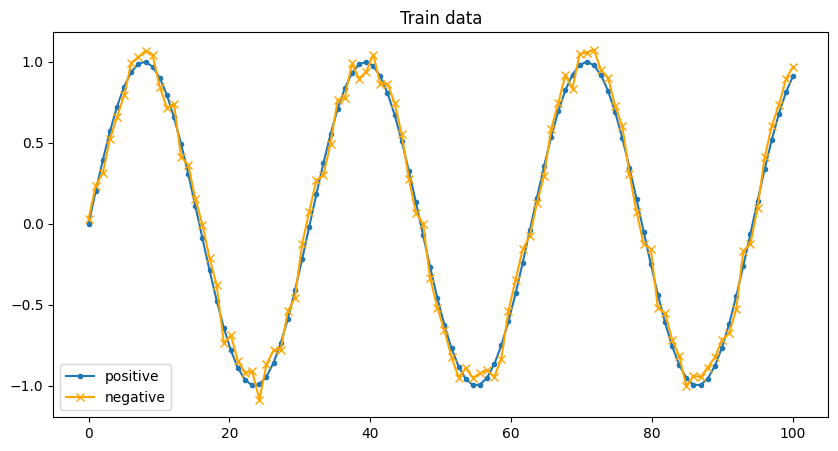

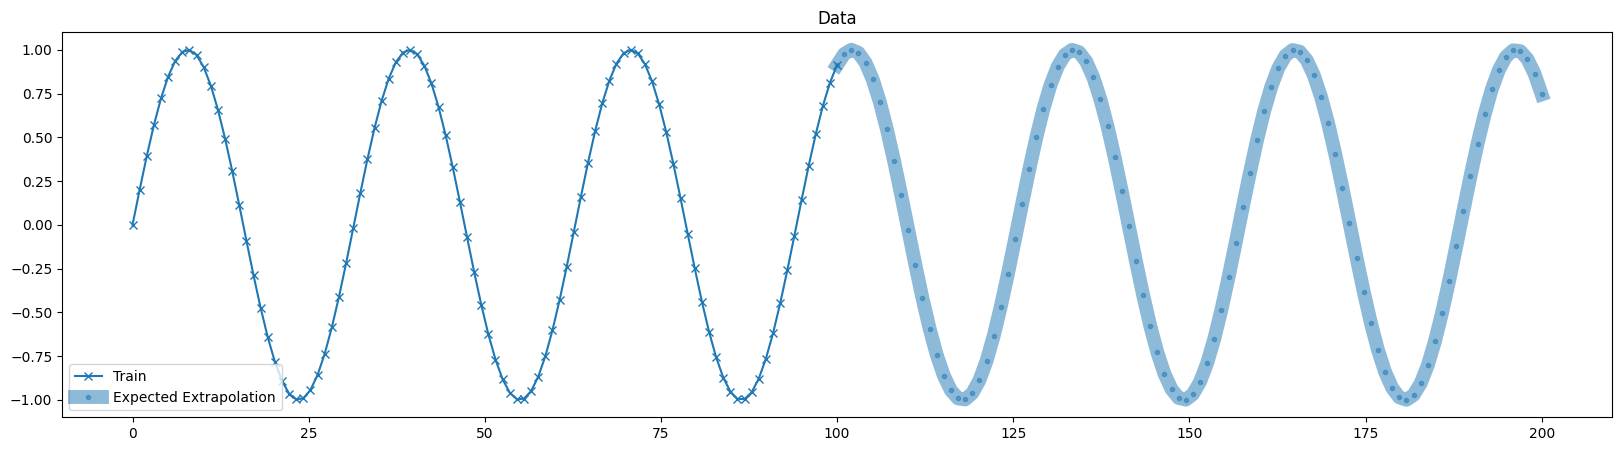

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 277.12it/s]


eval_mse: tr= 0.10916780680418015
eval_mse: te= 0.761237621307373
eval_mse avg: te avg= 0.4425012469291687
-----------------CFF----------------------
eval_mse: tr= [1.3164143562316895, 0.34118208289146423, 0.3679717481136322, 0.3701884150505066, 0.3729931116104126, 0.37331968545913696]
eval_mse: te= [11.581427574157715, 0.4393669068813324, 0.12412834912538528, 0.12220761179924011, 0.1420741081237793, 0.14586885273456573]  L 3 :  0.12220761179924011
avg_mse: te avg= [11.779967308044434, 0.591410219669342, 0.6974397301673889, 0.7142612338066101, 0.7417968511581421, 0.7432444095611572]  L 1 :  0.591410219669342


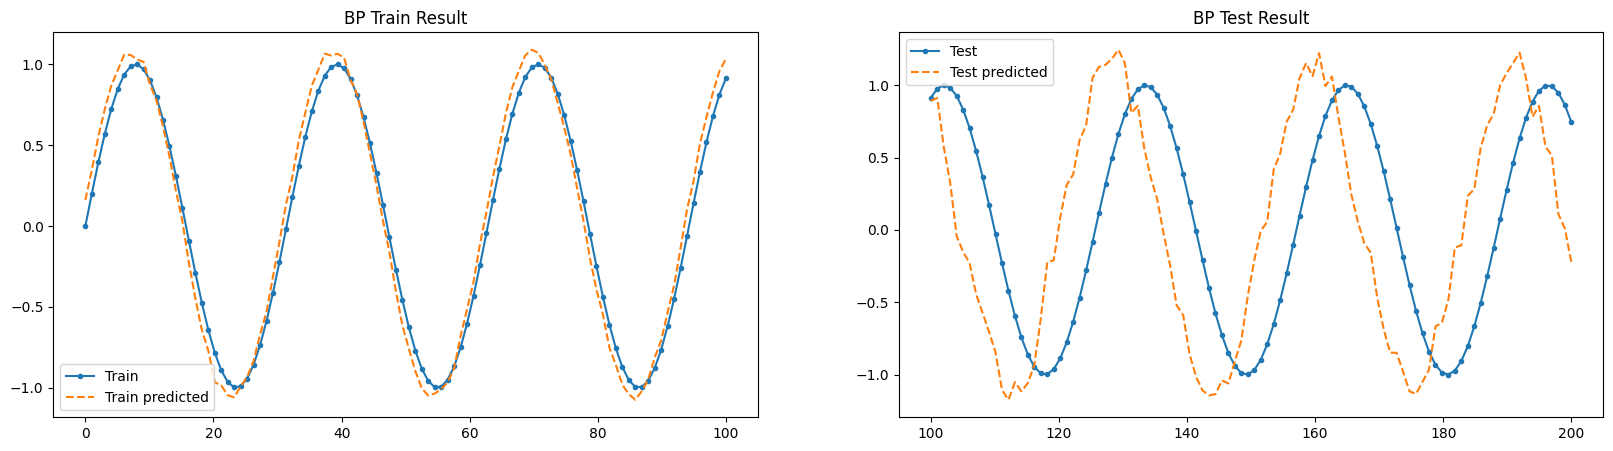

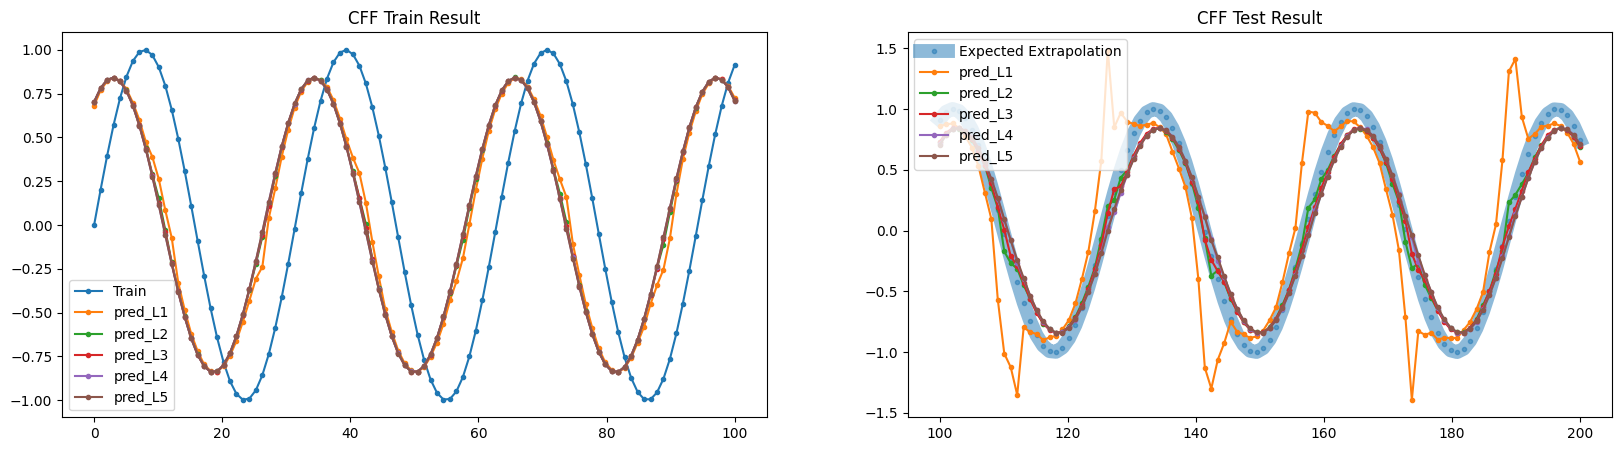

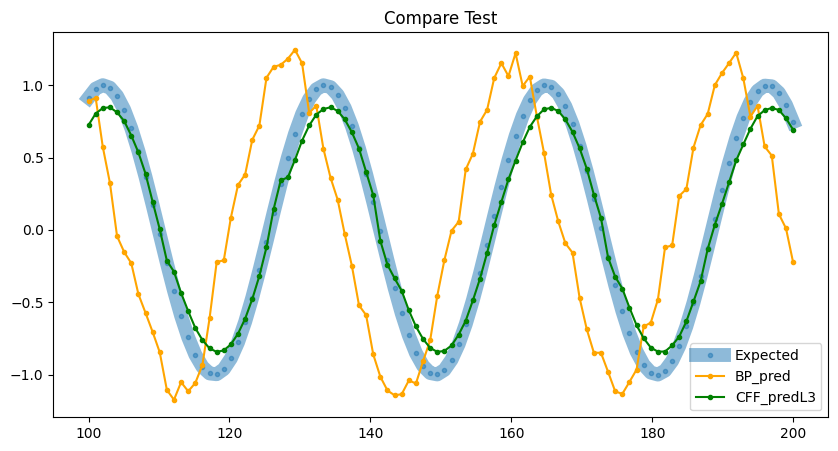

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 292.18it/s]


eval_mse: tr= 0.6144506931304932
eval_mse: te= 0.15256507694721222
eval_mse avg: te avg= 0.7487304210662842
-----------------CFF----------------------
eval_mse: tr= [1.3417733907699585, 0.3391311466693878, 0.36473992466926575, 0.3711423873901367, 0.37300777435302734, 0.37343740463256836]
eval_mse: te= [11.939842224121094, 0.4480270445346832, 0.12915046513080597, 0.13223546743392944, 0.1456908881664276, 0.14919167757034302]  L 2 :  0.12915046513080597
avg_mse: te avg= [12.152838706970215, 0.5827130675315857, 0.6721689105033875, 0.7235978841781616, 0.7416079044342041, 0.7446773648262024]  L 1 :  0.5827130675315857


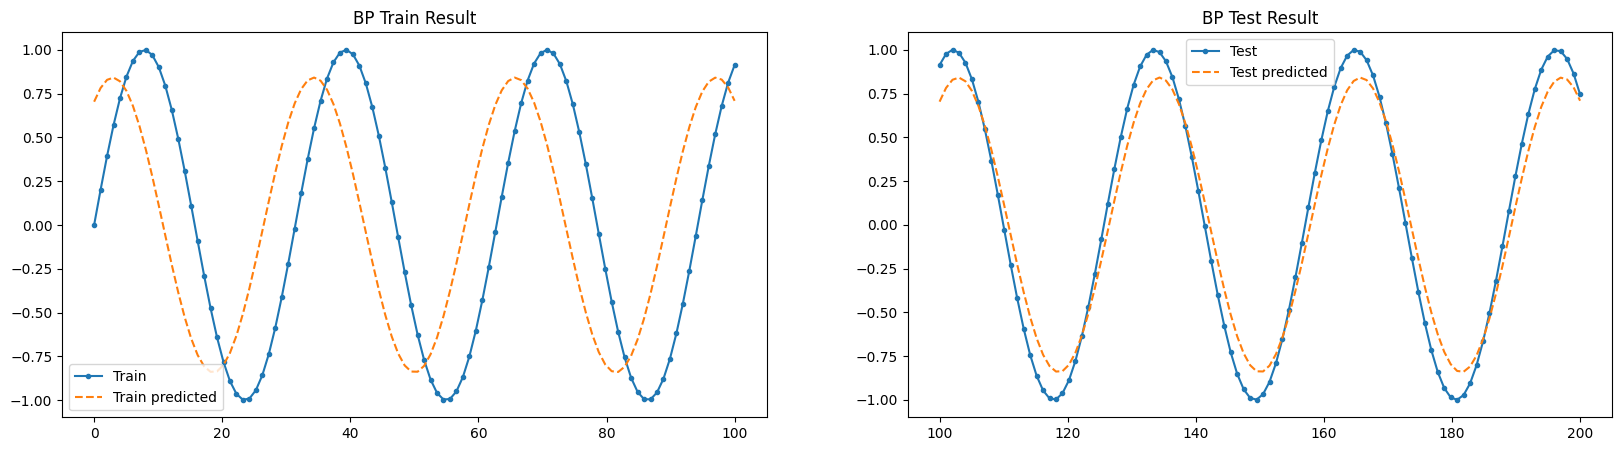

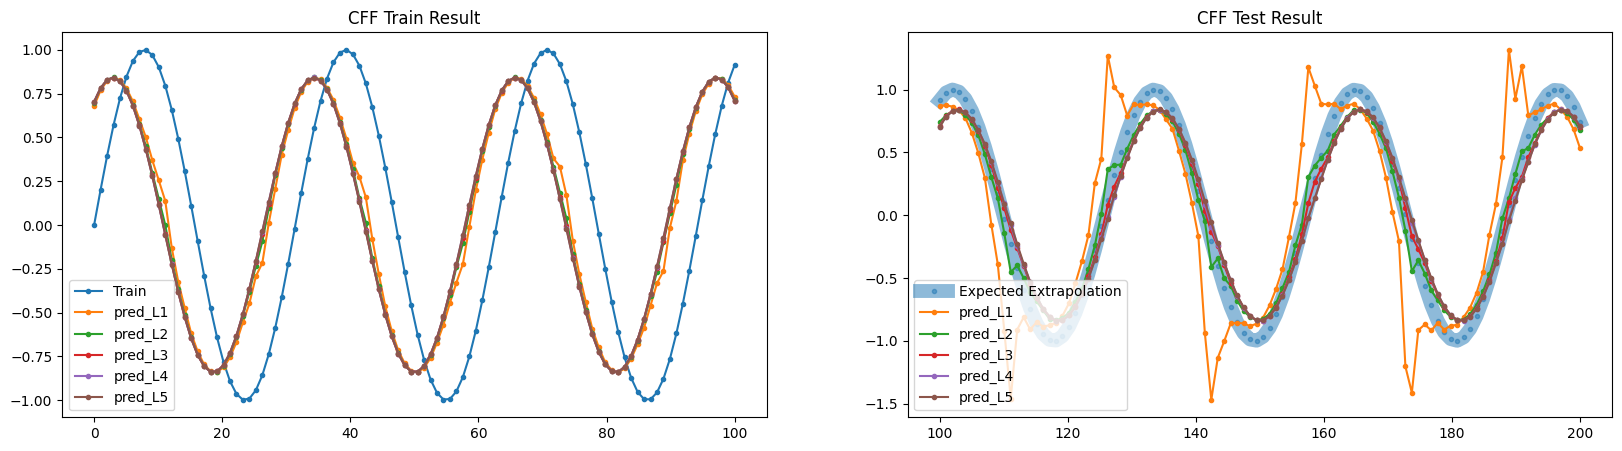

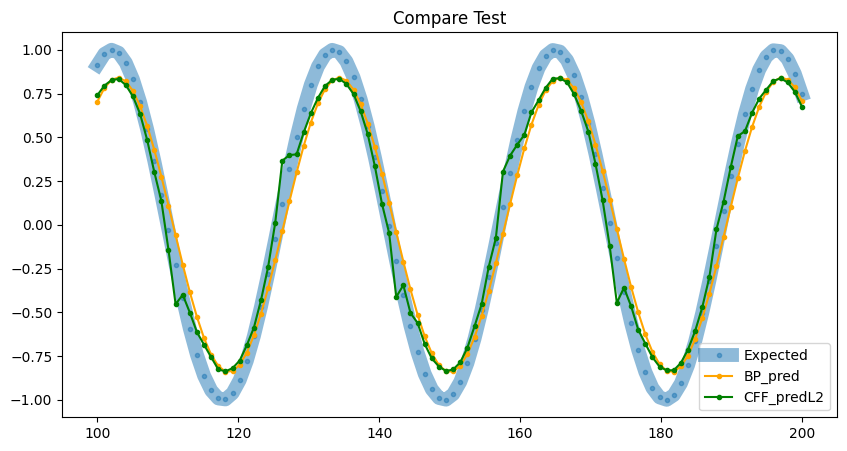

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 270.53it/s]


eval_mse: tr= 0.6144411563873291
eval_mse: te= 0.15255194902420044
eval_mse avg: te avg= 0.7487031817436218
-----------------CFF----------------------
eval_mse: tr= [1.2498923540115356, 0.3141342103481293, 0.3644937574863434, 0.3678114414215088, 0.37241631746292114, 0.37345197796821594]
eval_mse: te= [12.106222152709961, 0.7418532371520996, 0.13775727152824402, 0.11814035475254059, 0.1410176306962967, 0.14833369851112366]  L 3 :  0.11814035475254059
avg_mse: te avg= [12.312664985656738, 0.6610522270202637, 0.6801356077194214, 0.6911624670028687, 0.7357491850852966, 0.7448726296424866]  L 1 :  0.6610522270202637


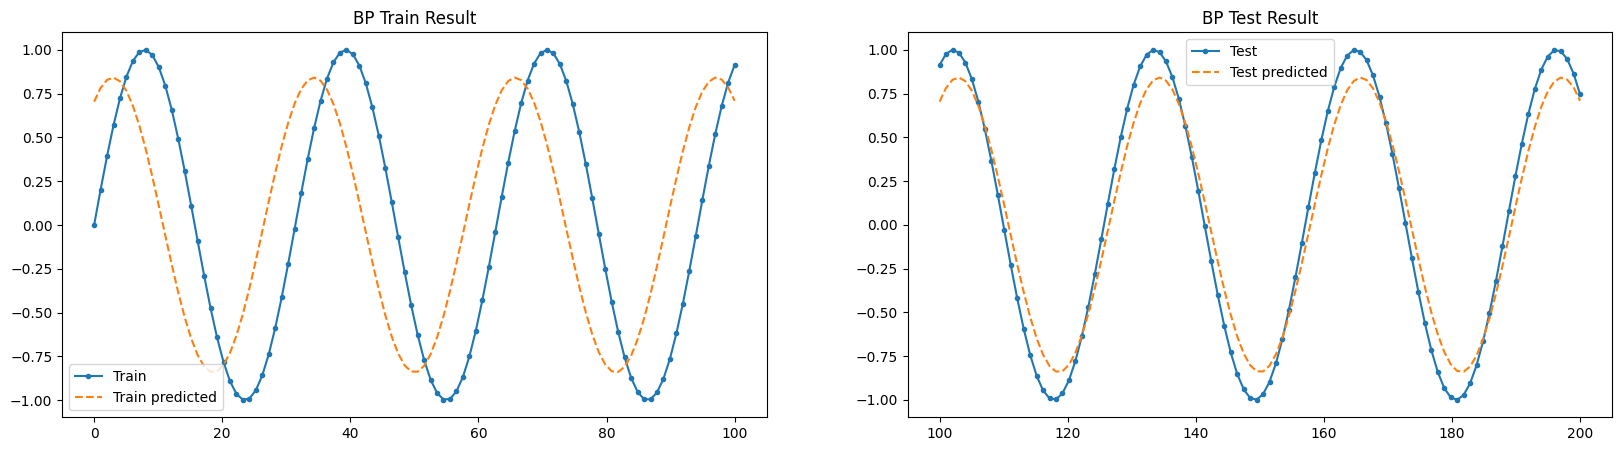

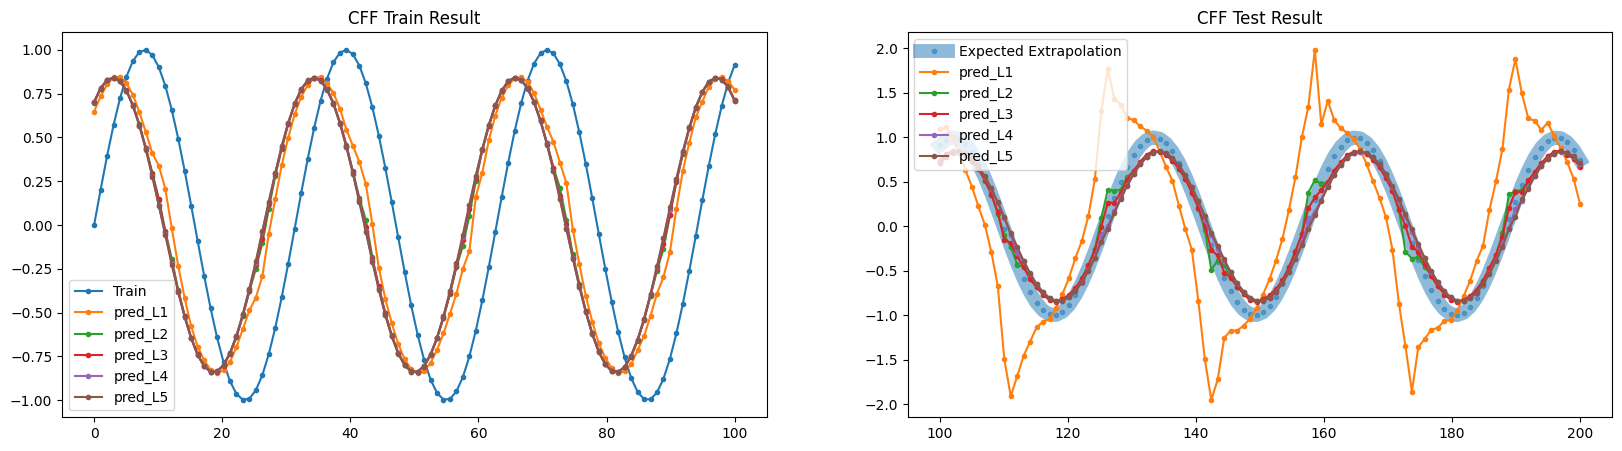

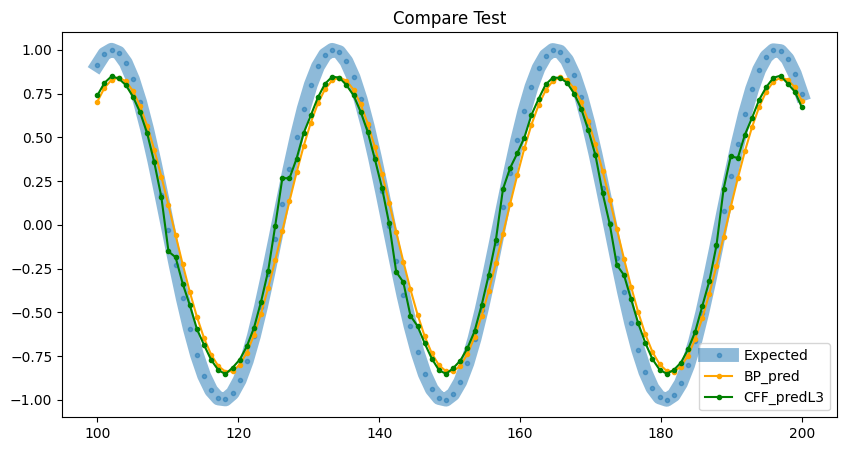

In [38]:
# Gen
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.sin(0.2*x), do_plot=True)
for _ in range(3):
    get_results(cff_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)

In [65]:
# Processing collected results
to_rate([0.15256507694721222, 0.761237621307373, 0.15255194902420044],
        [0.12915046513080597, 0.12220761179924011, 0.11814035475254059],
        range=2)

range 2
BP  [ 7.62825385 38.06188107  7.62759745] %
CFF [6.45752326 6.11038059 5.90701774] %
CFF better? (>0?) [ 1.17073059 31.95150048  1.72057971] %
--------------avg
BP avg 17.772577454646427 % BP_s avg 7.6279256492853165
CFF avg 6.158307194709778 %
Avg, CFF better? (>0?) 11.61427025993665 % stable_better= 1.4696184545755386


## cos

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 314.93it/s]


eval_mse: tr= 0.6379913091659546
eval_mse: te= 0.1528053879737854
eval_mse avg: te avg= 0.7541342377662659
-----------------CFF----------------------
eval_mse: tr= [1.8776254653930664, 0.3485284447669983, 0.3835197389125824, 0.38695892691612244, 0.3894817531108856, 0.3893328607082367]
eval_mse: te= [12.55510139465332, 0.512662410736084, 0.12180102616548538, 0.12701795995235443, 0.15119720995426178, 0.1467650979757309]  L 2 :  0.12180102616548538
avg_mse: te avg= [12.799704551696777, 0.5427728891372681, 0.6956952214241028, 0.7175889015197754, 0.7513659596443176, 0.7494738101959229]  L 1 :  0.5427728891372681


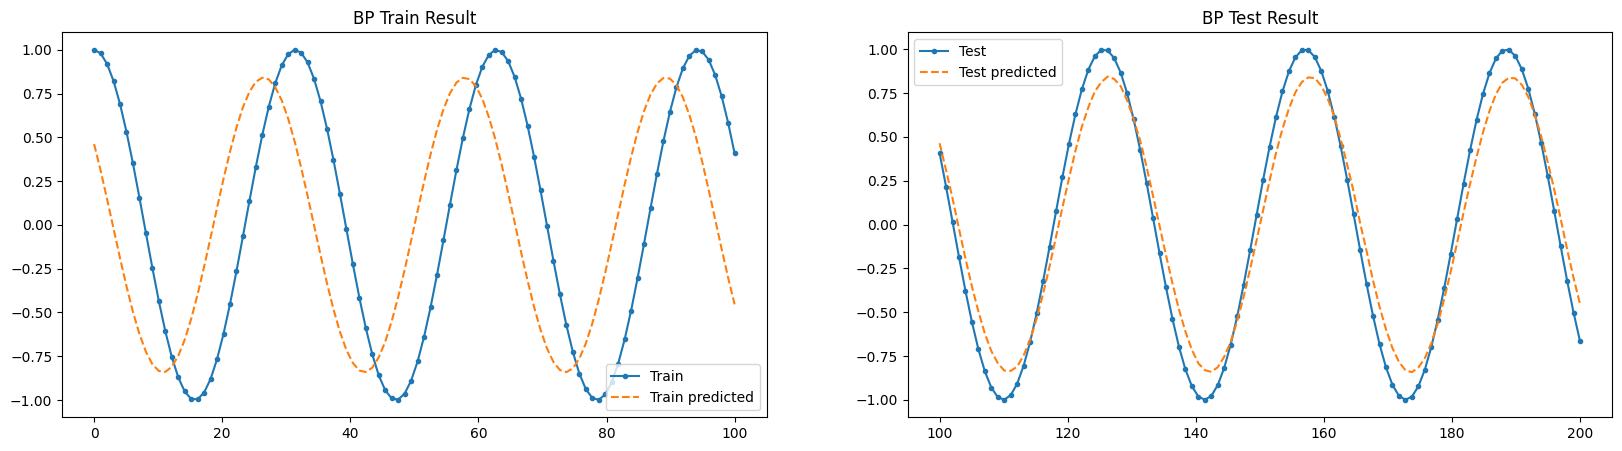

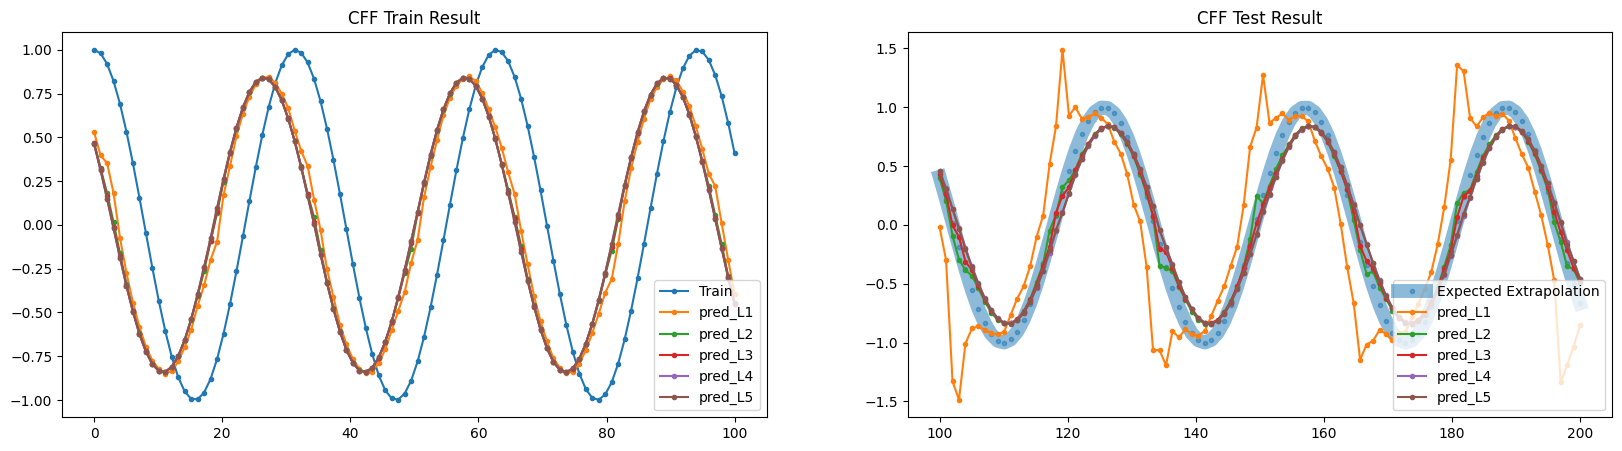

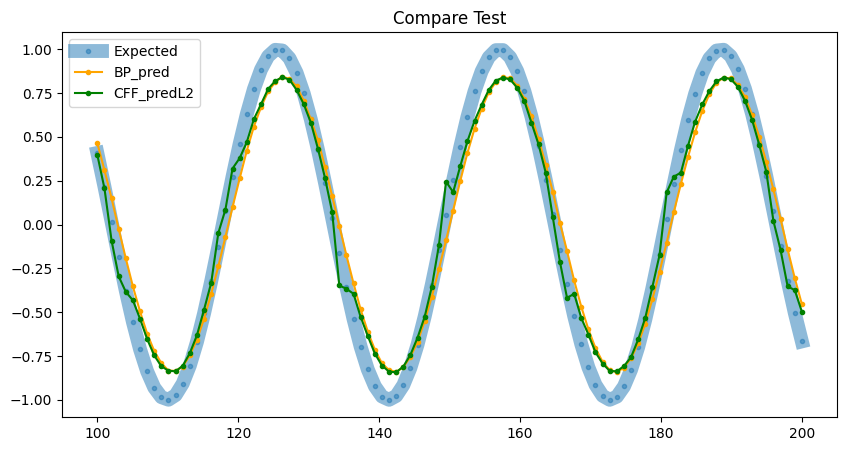

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 207.13it/s]


eval_mse: tr= 0.1700097918510437
eval_mse: te= 0.4781707525253296
eval_mse avg: te avg= 0.4416300654411316
-----------------CFF----------------------
eval_mse: tr= [1.9715522527694702, 0.3354223072528839, 0.3797992467880249, 0.3853781521320343, 0.38855546712875366, 0.38916629552841187]
eval_mse: te= [13.031669616699219, 0.7302215695381165, 0.1474626213312149, 0.12031512707471848, 0.1404770463705063, 0.14278601109981537]  L 3 :  0.12031512707471848
avg_mse: te avg= [13.268495559692383, 0.6433628797531128, 0.6580190658569336, 0.7077582478523254, 0.7357245087623596, 0.7454310059547424]  L 1 :  0.6433628797531128


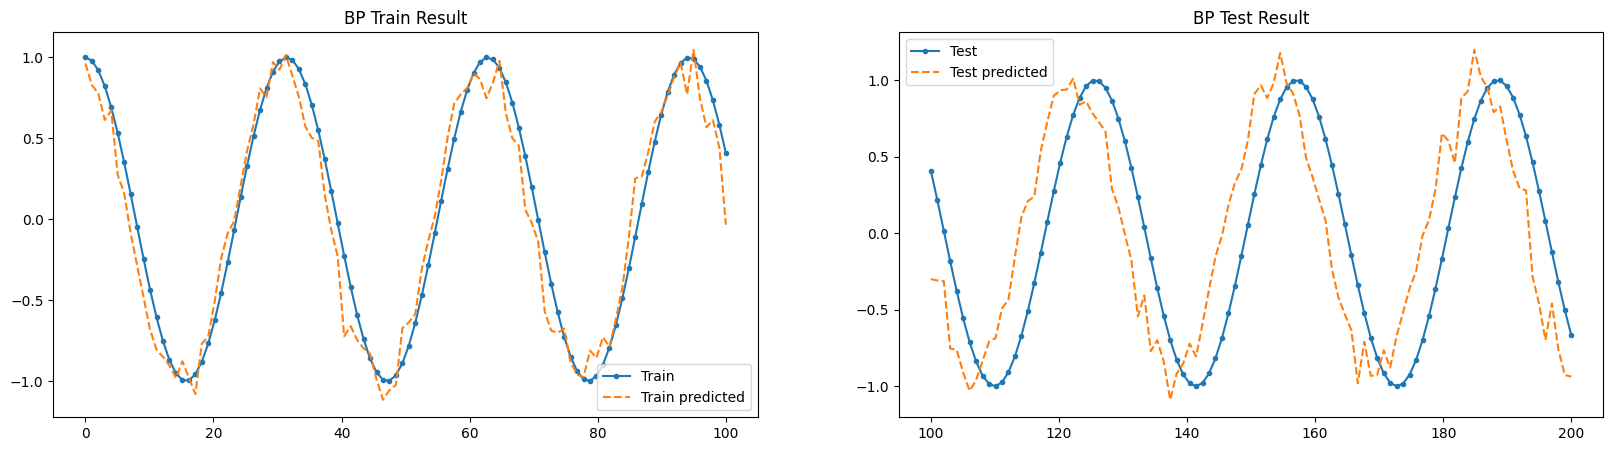

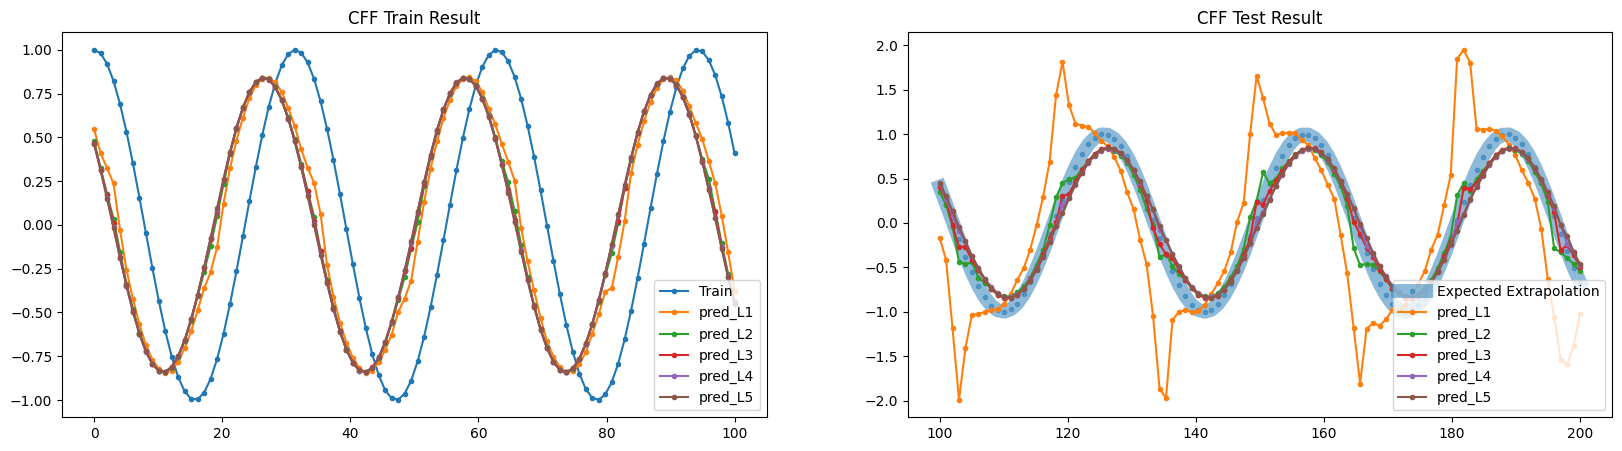

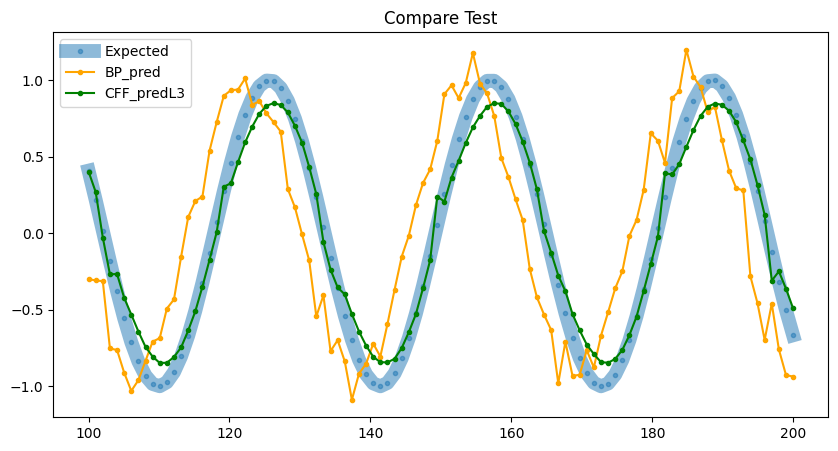

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 227.96it/s]


eval_mse: tr= 0.6588424444198608
eval_mse: te= 0.6388378739356995
eval_mse avg: te avg= 0.40497899055480957
-----------------CFF----------------------
eval_mse: tr= [1.4866210222244263, 0.3525715470314026, 0.3822791278362274, 0.3878762722015381, 0.38924598693847656, 0.38982853293418884]
eval_mse: te= [13.010664939880371, 0.366690993309021, 0.12580139935016632, 0.13721366226673126, 0.1439836472272873, 0.15111921727657318]  L 2 :  0.12580139935016632
avg_mse: te avg= [13.246599197387695, 0.558673083782196, 0.6878316402435303, 0.7345870733261108, 0.748015820980072, 0.7525292634963989]  L 1 :  0.558673083782196


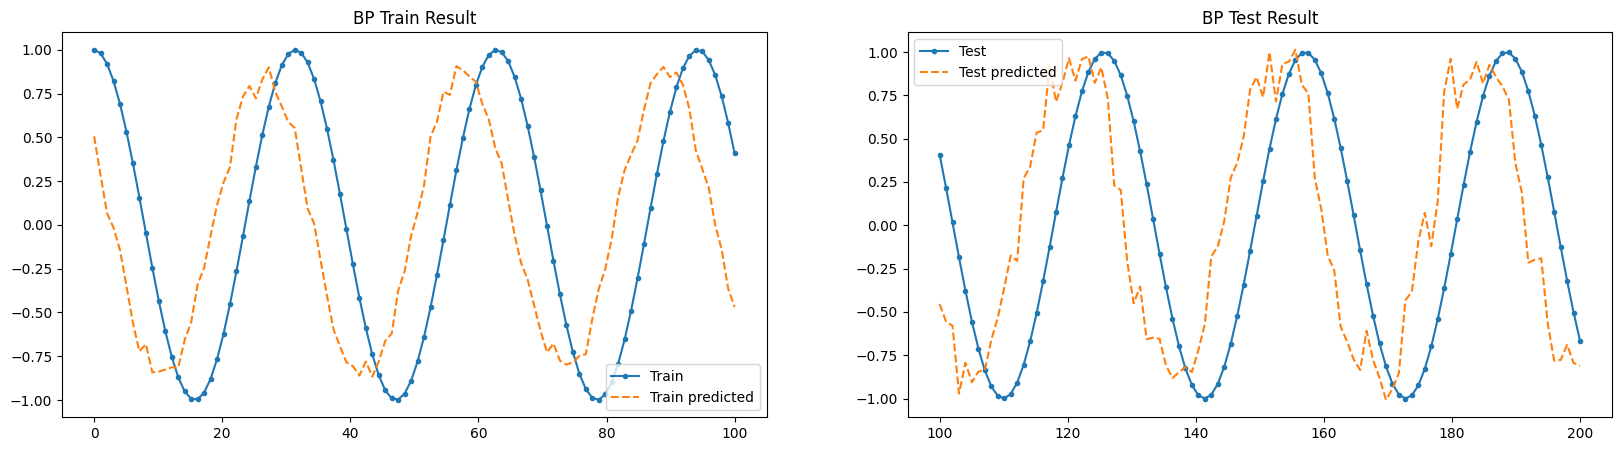

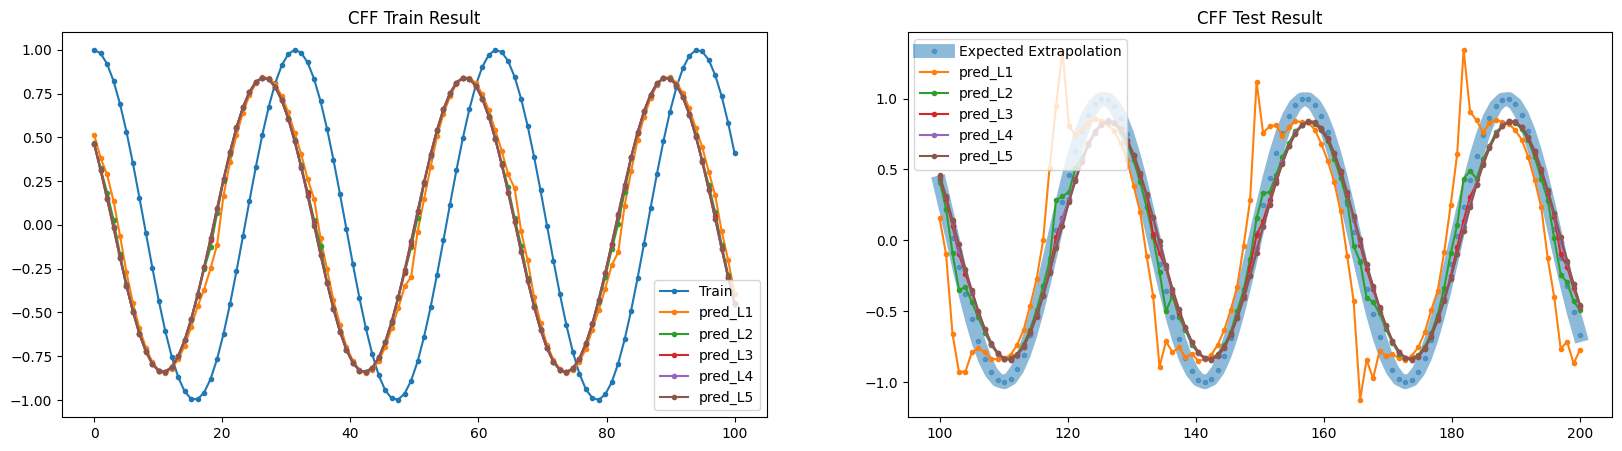

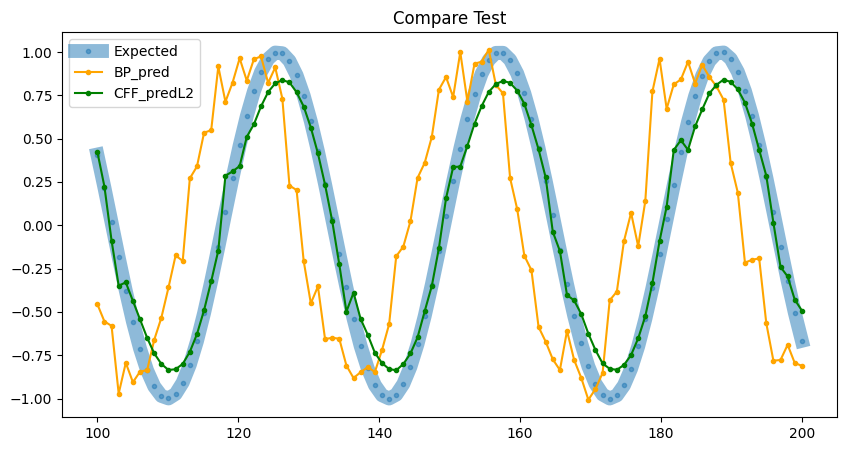

In [59]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.cos(0.2*x), do_plot=False)
for _ in range(3):
    get_results(cff_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)

In [60]:
to_rate([0.1528053879737854, 0.4781707525253296, 0.6388378739356995],
        [0.12180102616548538, 0.12031512707471848, 0.12580139935016632],
        range=2)

range 2
BP  [ 7.6402694  23.90853763 31.9418937 ] %
CFF [6.09005131 6.01575635 6.29006997] %
CFF better? (>0?) [ 1.55021809 17.89278127 25.65182373] %
--------------avg
BP avg 21.163566907246906 % BP_s avg 7.64026939868927
CFF avg 6.131959209839503 %
Avg, CFF better? (>0?) 15.031607697407402 % stable_better= 1.5083101888497668


## sin cos

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 310.06it/s]


eval_mse: tr= 0.248609721660614
eval_mse: te= 0.05929385498166084
eval_mse avg: te avg= 0.28524020314216614
-----------------CFF----------------------
eval_mse: tr= [1.33916437625885, 0.10729562491178513, 0.1468297690153122, 0.14677292108535767, 0.15214593708515167, 0.1510525345802307]
eval_mse: te= [5.374485015869141, 0.5915080904960632, 0.0669979676604271, 0.06288696825504303, 0.054497428238391876, 0.04920889064669609]  L 5 :  0.04920889064669609
avg_mse: te avg= [5.5012736320495605, 0.48577067255973816, 0.24692095816135406, 0.24193790555000305, 0.2876436710357666, 0.27851057052612305]  L 3 :  0.24193790555000305


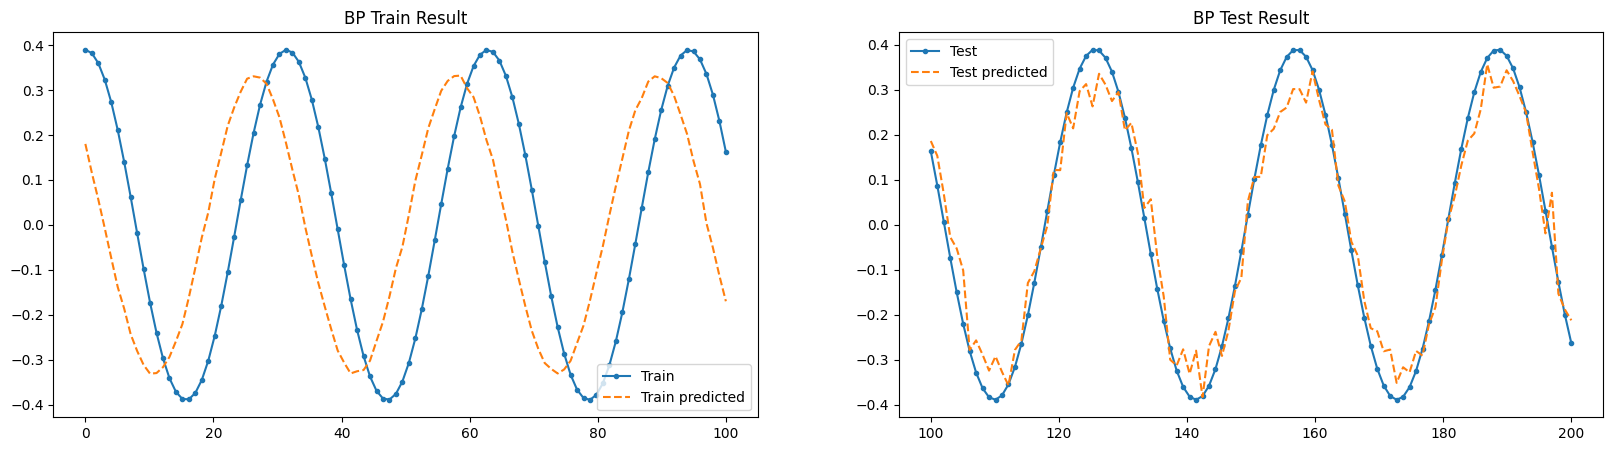

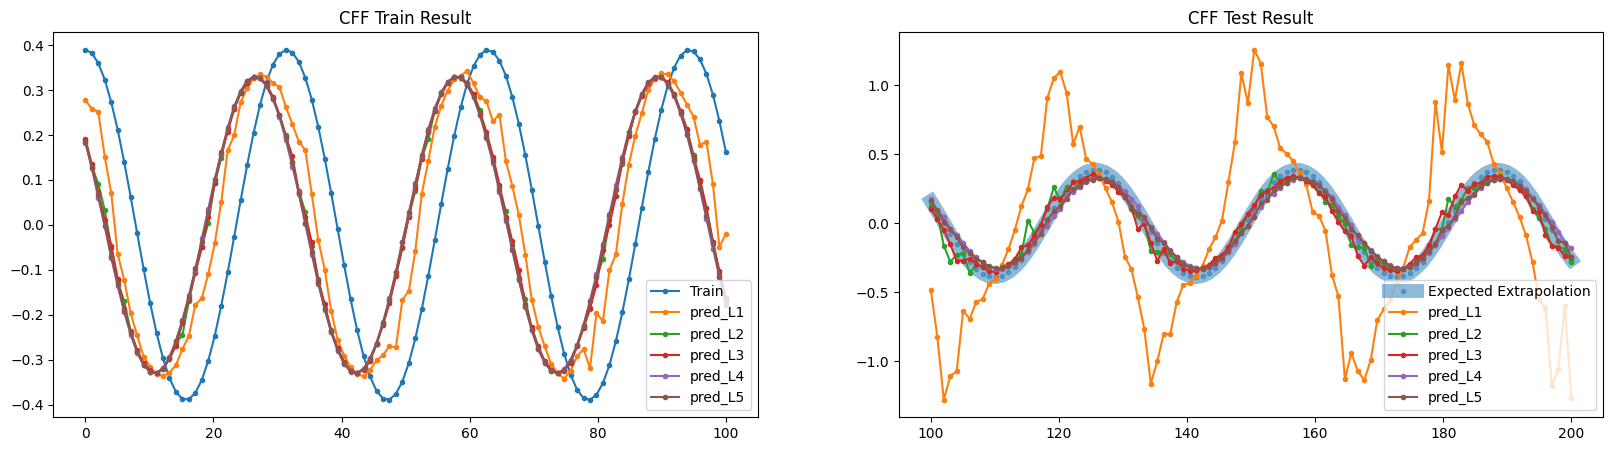

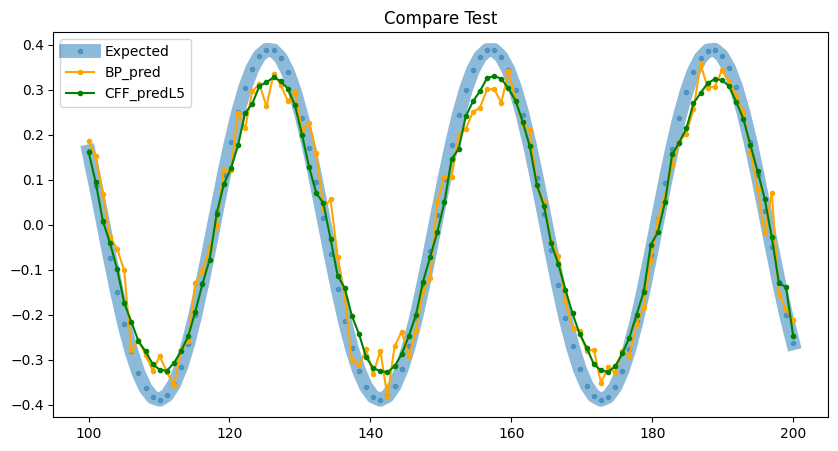

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 207.27it/s]


eval_mse: tr= 0.055048588663339615
eval_mse: te= 0.28934431076049805
eval_mse avg: te avg= 0.20672424137592316
-----------------CFF----------------------
eval_mse: tr= [1.087462306022644, 0.10198979079723358, 0.13785530626773834, 0.1466486155986786, 0.15058952569961548, 0.1520383059978485]
eval_mse: te= [5.70055627822876, 0.6274058222770691, 0.1779787391424179, 0.06291890889406204, 0.047085314989089966, 0.05088858678936958]  L 4 :  0.047085314989089966
avg_mse: te avg= [5.818932056427002, 0.5168081521987915, 0.21833519637584686, 0.24785256385803223, 0.27767083048820496, 0.2865602970123291]  L 2 :  0.21833519637584686


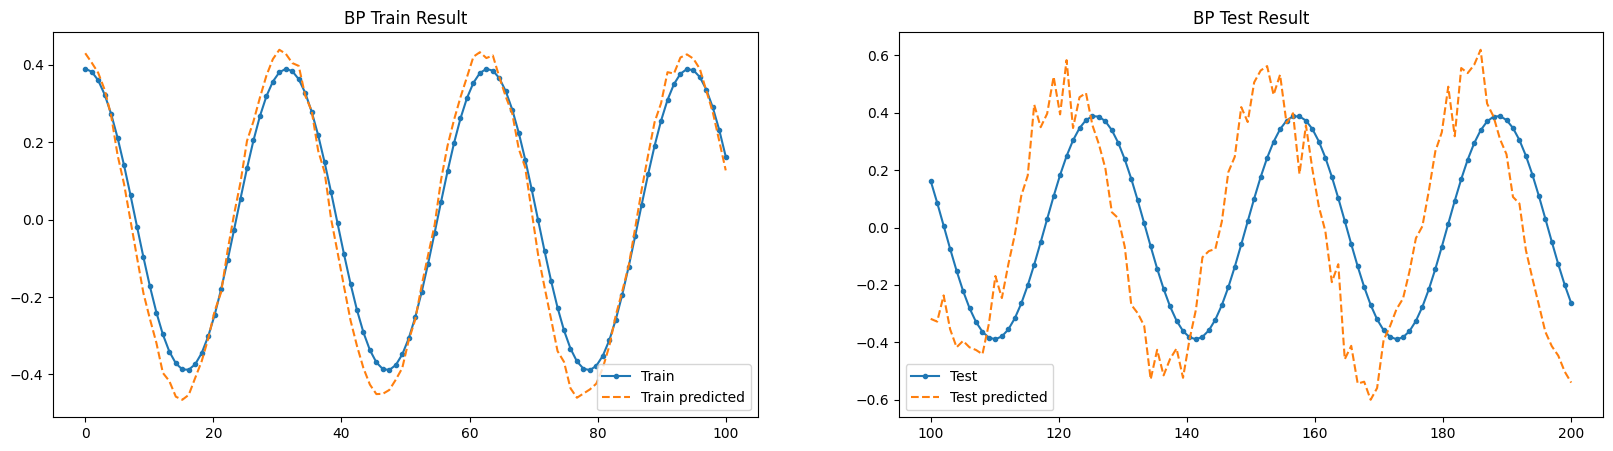

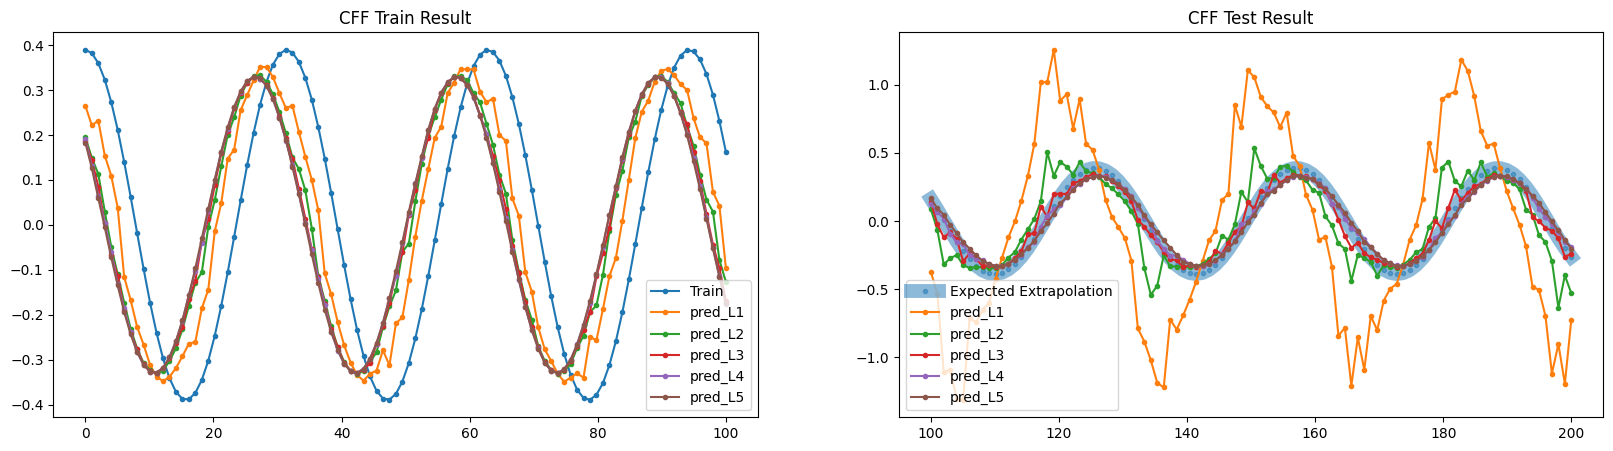

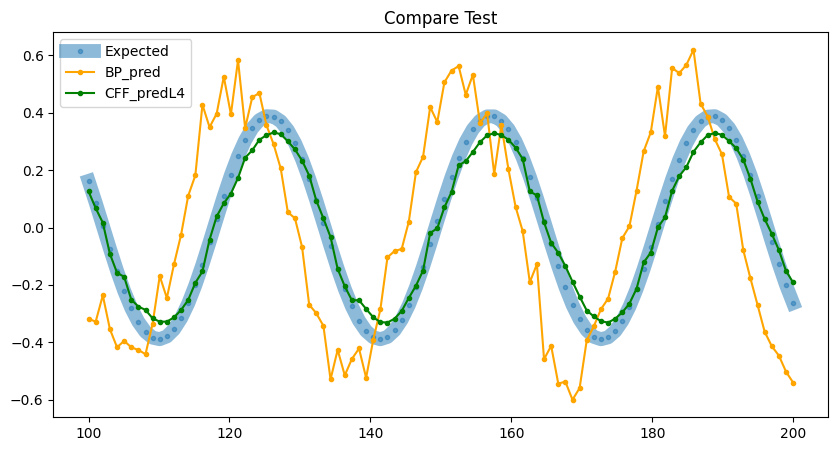

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 274.58it/s]


eval_mse: tr= 0.07179399579763412
eval_mse: te= 0.12253332138061523
eval_mse avg: te avg= 0.22005531191825867
-----------------CFF----------------------
eval_mse: tr= [1.5495308637619019, 0.11473987996578217, 0.14603936672210693, 0.15009096264839172, 0.15217241644859314, 0.15228137373924255]
eval_mse: te= [6.190455913543701, 0.5143049359321594, 0.08257633447647095, 0.04439627751708031, 0.05295180156826973, 0.05243847146630287]  L 3 :  0.04439627751708031
avg_mse: te avg= [6.360416412353516, 0.41383594274520874, 0.2384994626045227, 0.2688736617565155, 0.287251740694046, 0.2888677418231964]  L 2 :  0.2384994626045227


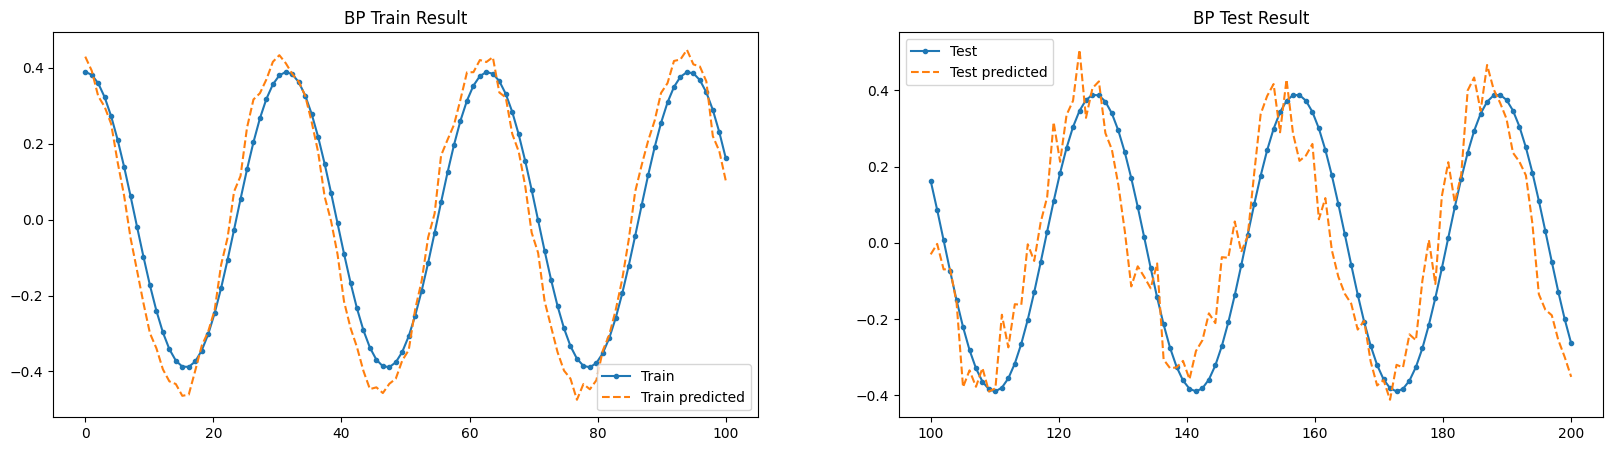

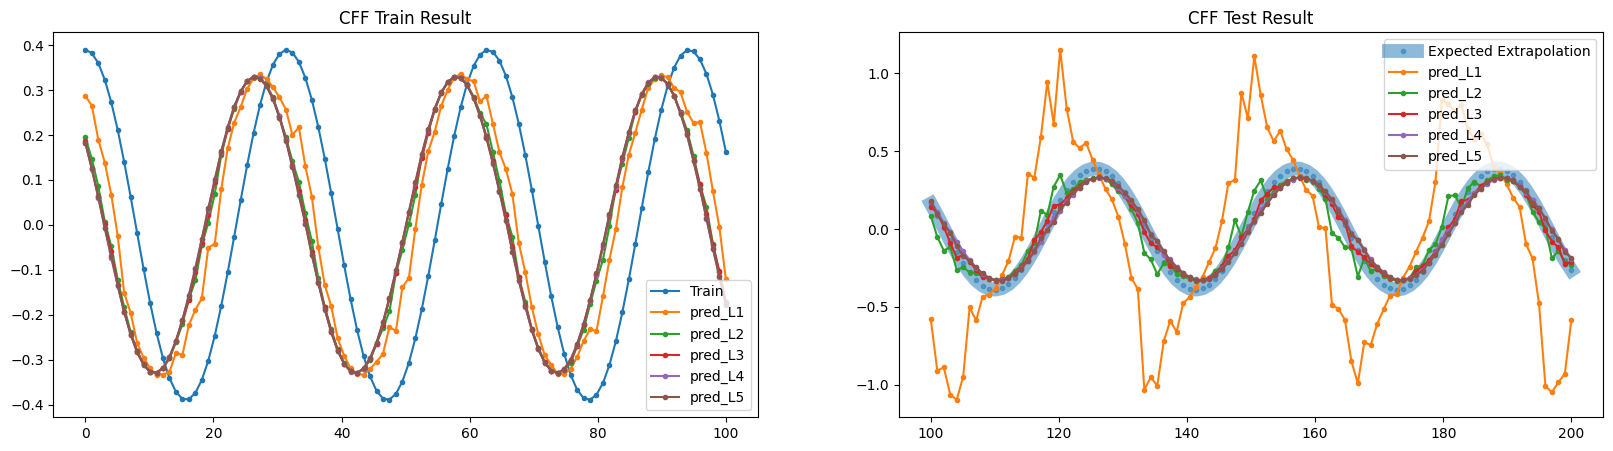

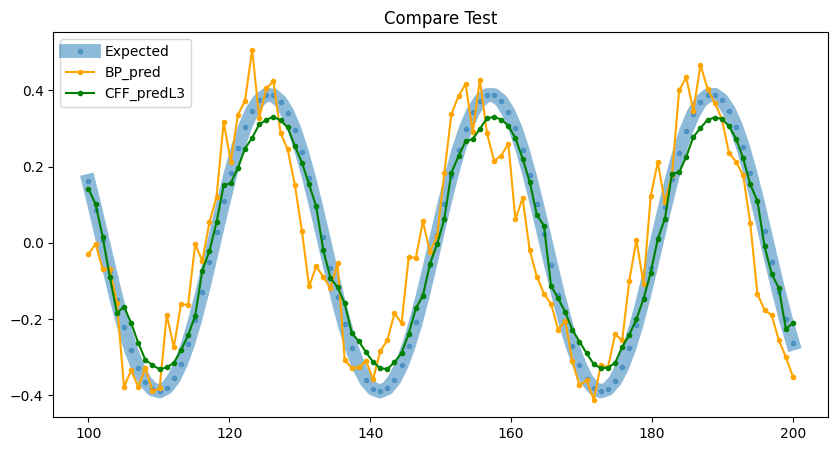

In [44]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.sin(0.4*np.cos(0.2*x)), do_plot=False)
for _ in range(3):
    get_results(cff_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)

In [61]:
to_rate([0.05929385498166084, 0.28934431076049805, 0.12253332138061523],
        [0.04920889064669609, 0.047085314989089966, 0.04439627751708031],
        range=0.8)

range 0.8
BP  [ 7.41173187 36.16803885 15.31666517] %
CFF [6.15111133 5.88566437 5.54953469] %
CFF better? (>0?) [ 1.26062054 30.28237447  9.76713048] %
--------------avg
BP avg 19.632145296782255 % BP_s avg 7.411731872707605
CFF avg 5.862103464702765 %
Avg, CFF better? (>0?) 13.770041832079489 % stable_better= 1.54962840800484


## sin cos c

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 313.62it/s]


eval_mse: tr= 0.053779441863298416
eval_mse: te= 0.021373968571424484
eval_mse avg: te avg= 0.05637524276971817
-----------------CFF----------------------
eval_mse: tr= [1.8441658020019531, 0.024002978578209877, 0.030973000451922417, 0.03335028886795044, 0.03390263766050339, 0.03395314887166023]
eval_mse: te= [4.469515323638916, 0.12303408235311508, 0.033491350710392, 0.015491769649088383, 0.018431495875120163, 0.018863746896386147]  L 3 :  0.015491769649088383
avg_mse: te avg= [4.608475208282471, 0.1166476160287857, 0.04889870434999466, 0.05098024383187294, 0.05462326854467392, 0.05484222248196602]  L 2 :  0.04889870434999466


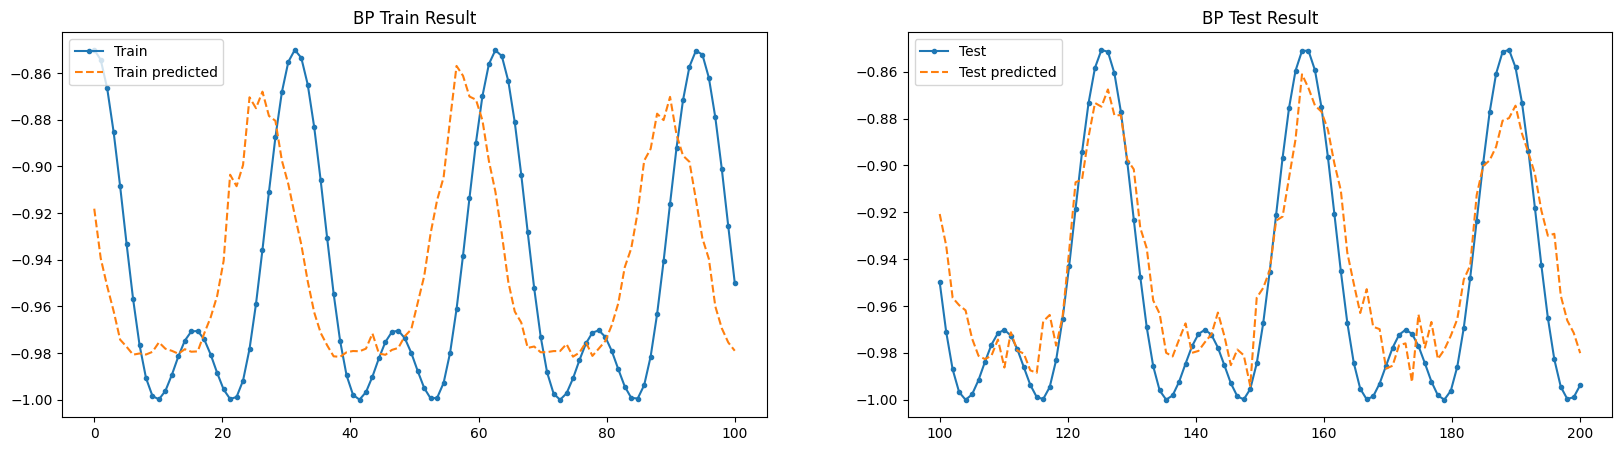

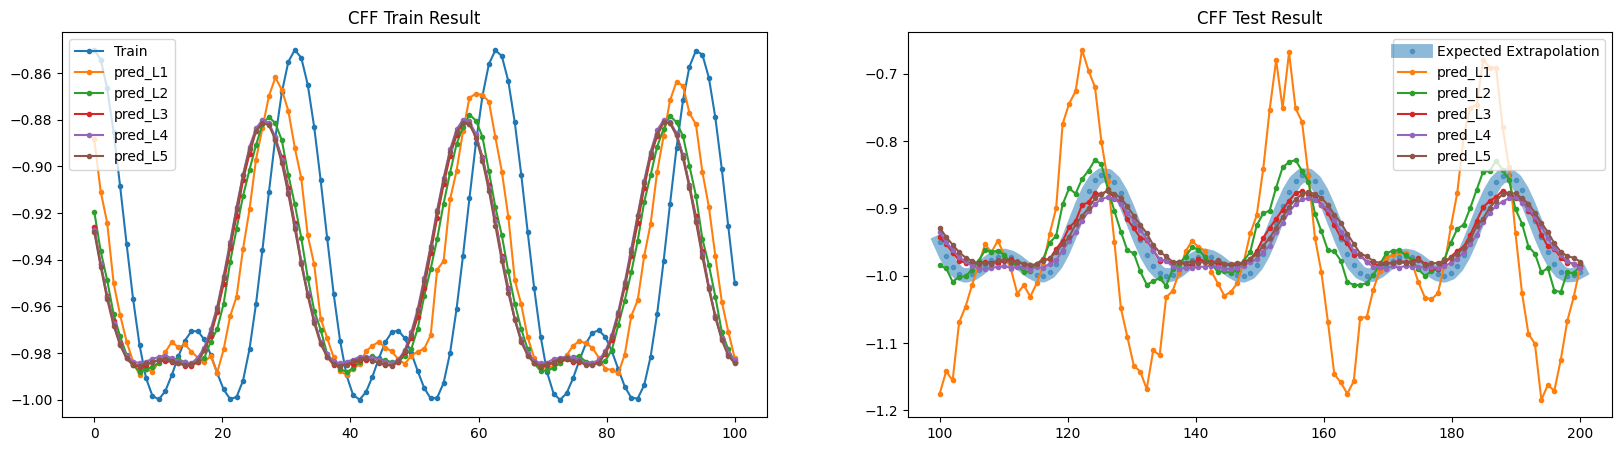

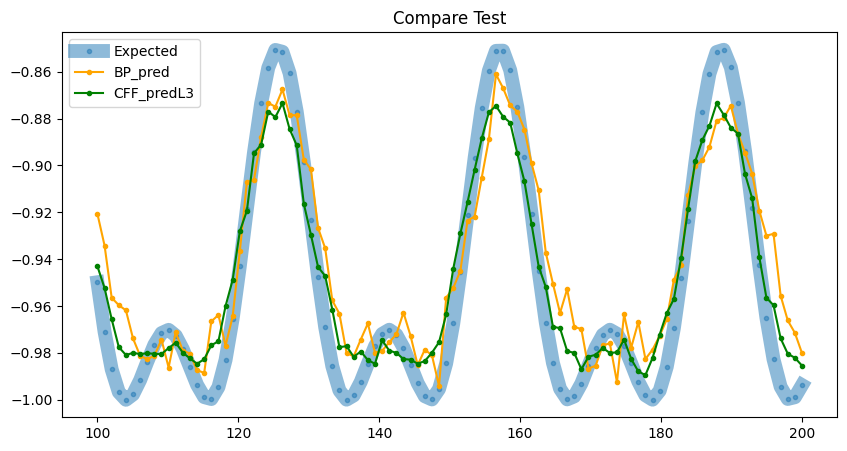

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 295.02it/s]


eval_mse: tr= 0.05249205231666565
eval_mse: te= 0.0194139052182436
eval_mse avg: te avg= 0.0590004064142704
-----------------CFF----------------------
eval_mse: tr= [1.5520097017288208, 0.021117903292179108, 0.03167339041829109, 0.033221352845430374, 0.0339253693819046, 0.03402407467365265]
eval_mse: te= [3.628974199295044, 0.2007167488336563, 0.023482637479901314, 0.015733642503619194, 0.018414614722132683, 0.019589701667428017]  L 3 :  0.015733642503619194
avg_mse: te avg= [3.734912157058716, 0.19162268936634064, 0.04726517200469971, 0.051214348524808884, 0.05457819253206253, 0.05504494905471802]  L 2 :  0.04726517200469971


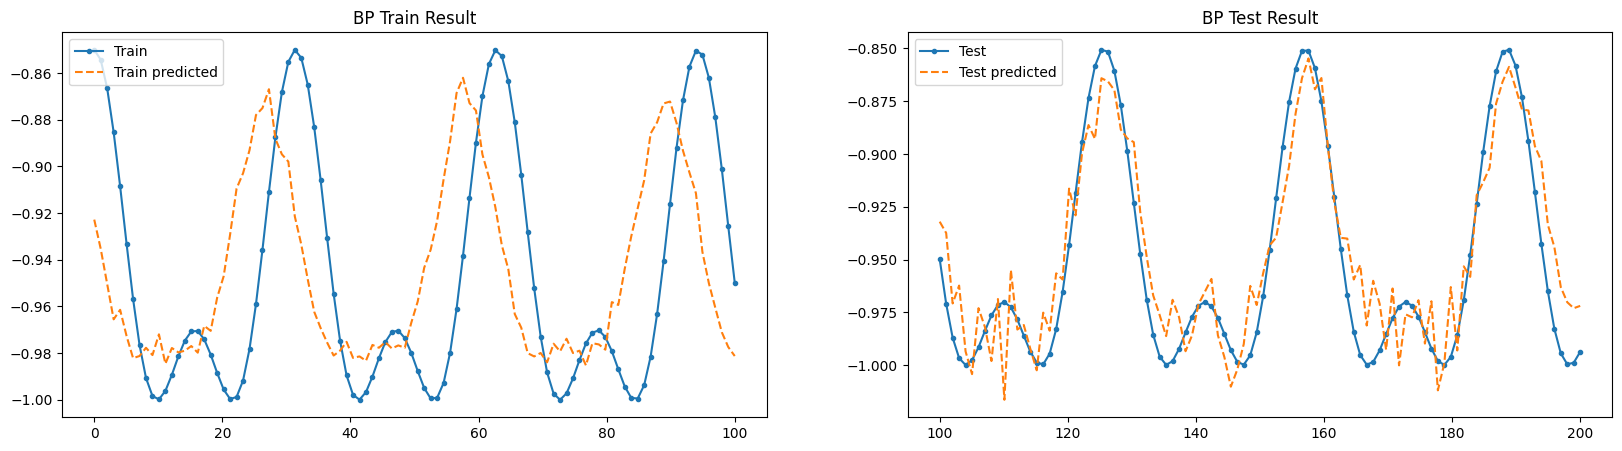

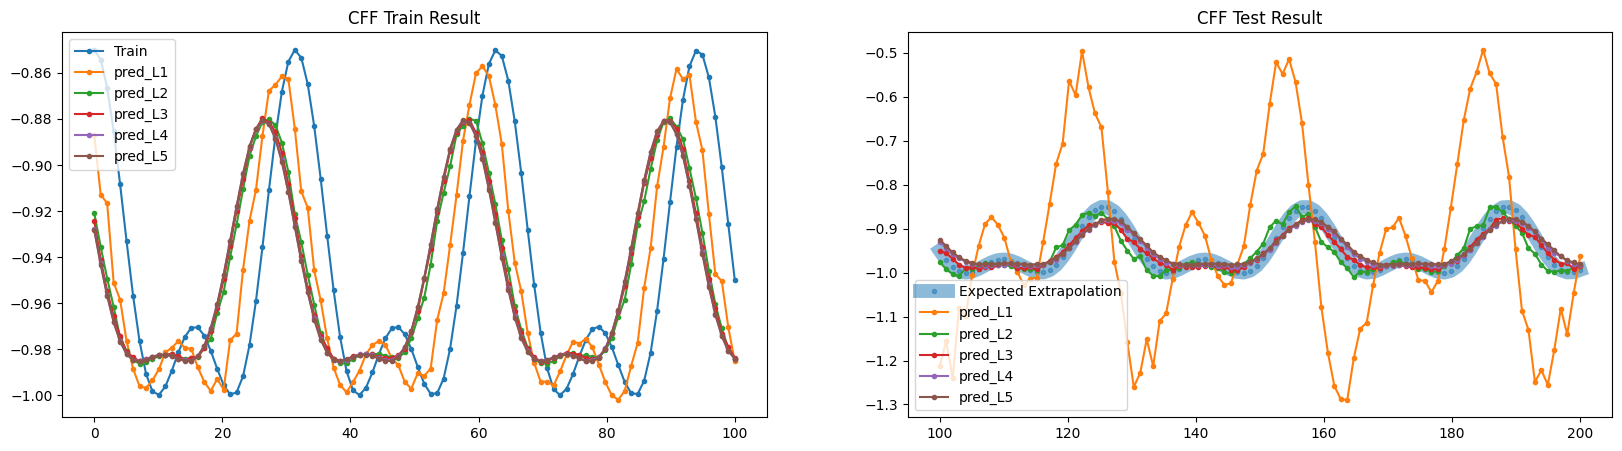

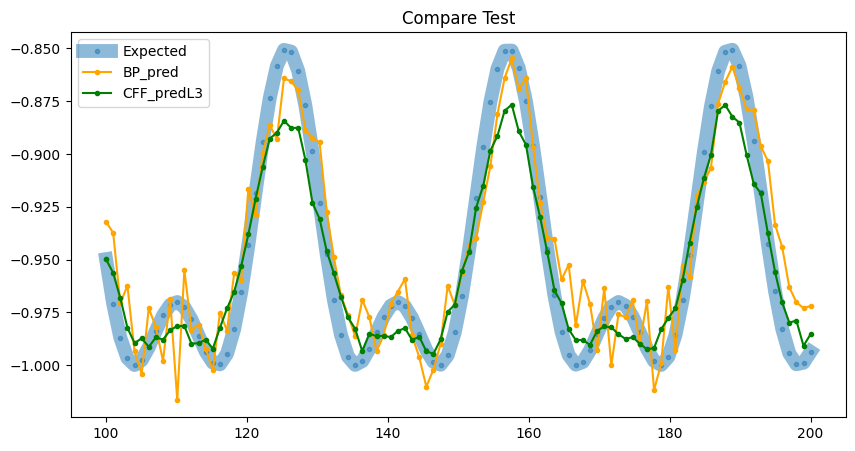

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:01<00:00, 194.74it/s]


eval_mse: tr= 0.05399312078952789
eval_mse: te= 0.0198756642639637
eval_mse avg: te avg= 0.05722088739275932
-----------------CFF----------------------
eval_mse: tr= [1.3846360445022583, 0.02449747547507286, 0.032269712537527084, 0.03293771669268608, 0.0338379442691803, 0.033834878355264664]
eval_mse: te= [3.616842269897461, 0.12422940880060196, 0.018087908625602722, 0.015510596334934235, 0.018283605575561523, 0.018545756116509438]  L 3 :  0.015510596334934235
avg_mse: te avg= [3.726407766342163, 0.11794720590114594, 0.04842521250247955, 0.04909254610538483, 0.05437544360756874, 0.05460934340953827]  L 2 :  0.04842521250247955


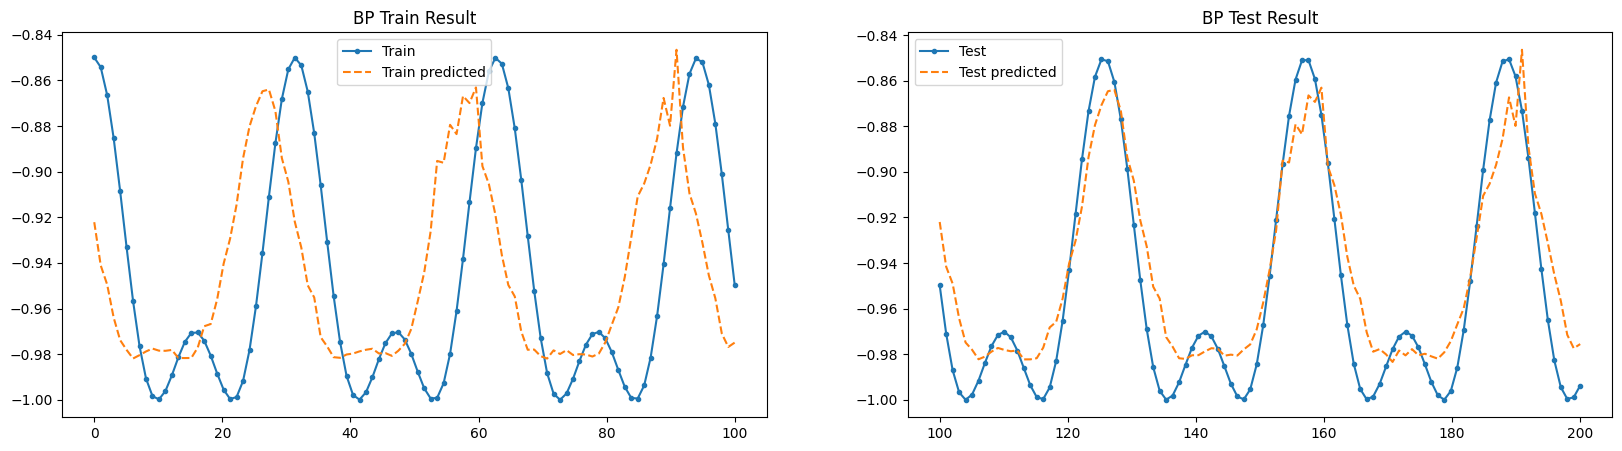

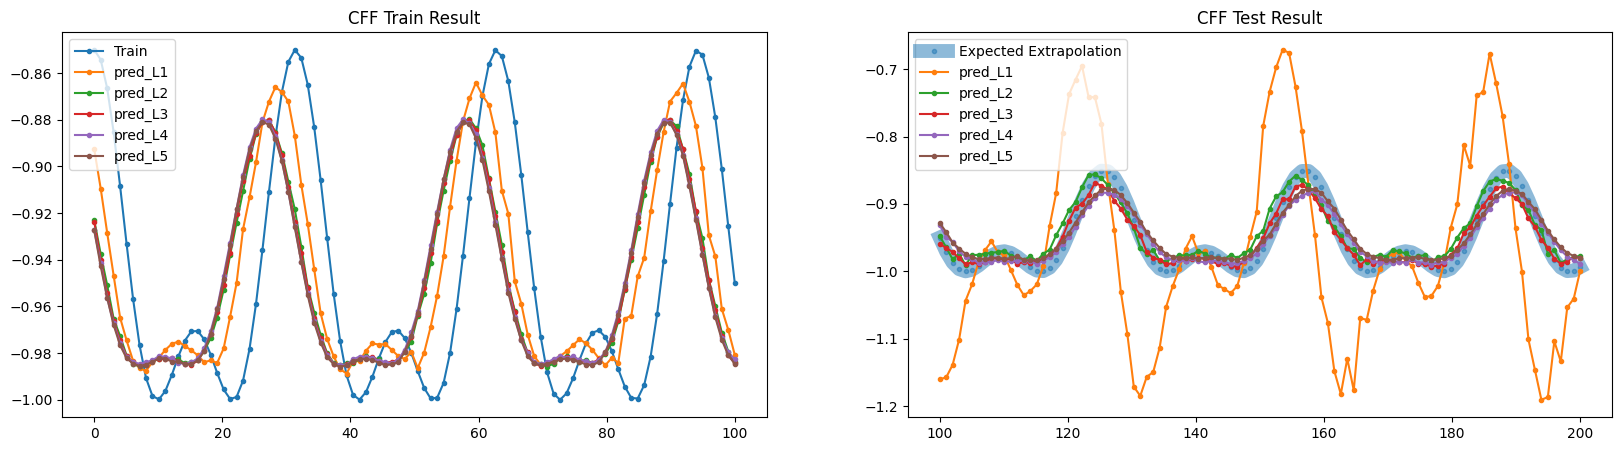

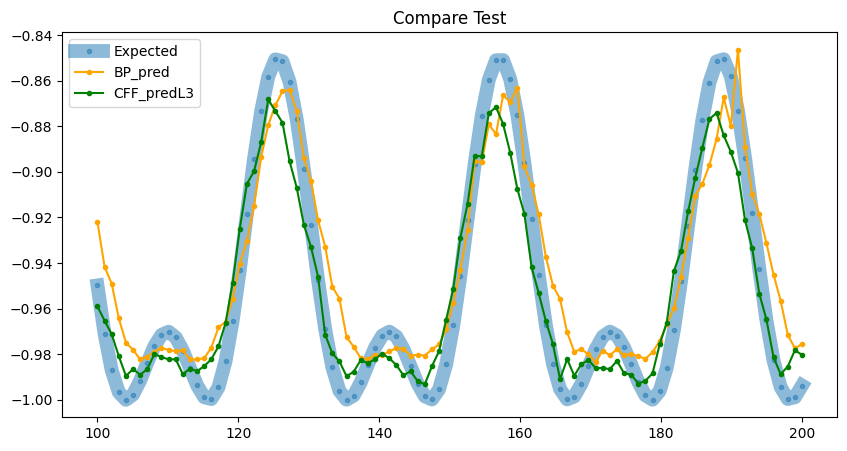

In [47]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.sin(0.4*np.cos(0.2*x)+30), do_plot=False)
for _ in range(3):
    get_results(cff_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)

In [62]:
to_rate([0.021373968571424484, 0.0194139052182436, 0.0198756642639637],
        [0.015491769649088383, 0.015733642503619194, 0.015510596334934235],
        range=0.15)

range 0.15
BP  [14.24931238 12.94260348 13.25044284] %
CFF [10.32784643 10.489095   10.34039756] %
CFF better? (>0?) [3.92146595 2.45350848 2.91004529] %
--------------avg
BP avg 13.480786234140396 % BP_s avg nan
CFF avg 10.385779663920403 %
Avg, CFF better? (>0?) 3.0950065702199936 % stable_better= nan


<ipython-input-35-4304e86423a8>:14: RuntimeWarning: Mean of empty slice.
  BeSA = BeS.mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## sin a cos c

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 297.60it/s]


eval_mse: tr= 0.22260113060474396
eval_mse: te= 0.07136176526546478
eval_mse avg: te avg= 0.262836217880249
-----------------CFF----------------------
eval_mse: tr= [1.59102201461792, 0.12050016224384308, 0.13823795318603516, 0.14249369502067566, 0.14613789319992065, 0.1463555246591568]
eval_mse: te= [6.0931854248046875, 0.3119869530200958, 0.09559603780508041, 0.0627288967370987, 0.07013900578022003, 0.07215294241905212]  L 3 :  0.0627288967370987
avg_mse: te avg= [6.274143218994141, 0.28904446959495544, 0.21241356432437897, 0.23318390548229218, 0.2589346766471863, 0.26142701506614685]  L 2 :  0.21241356432437897


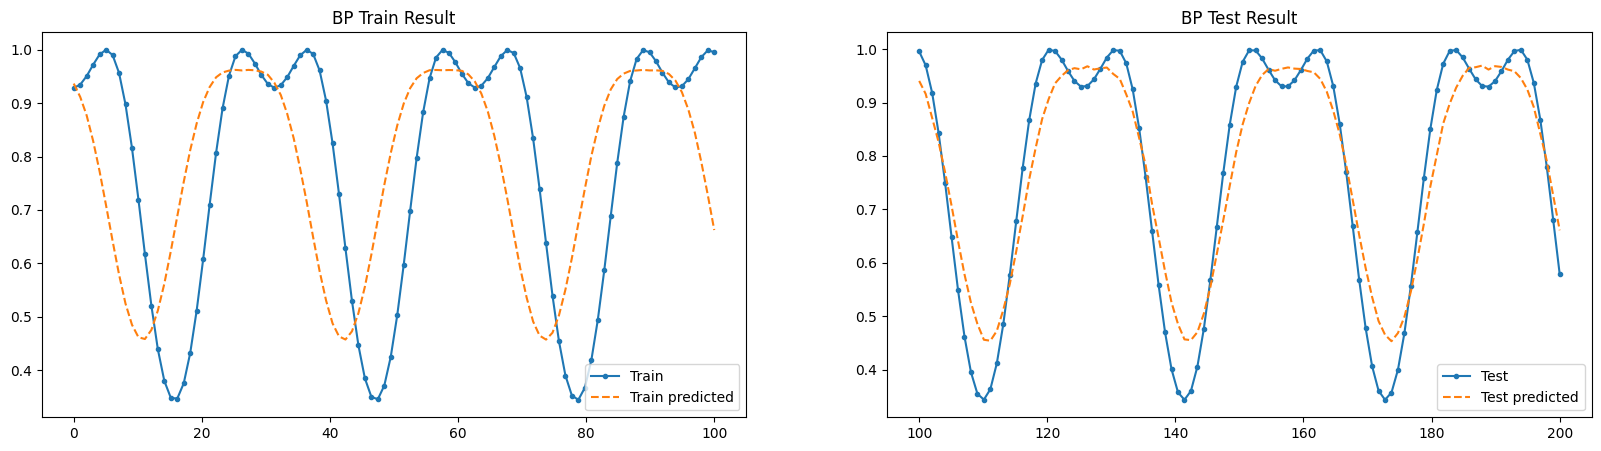

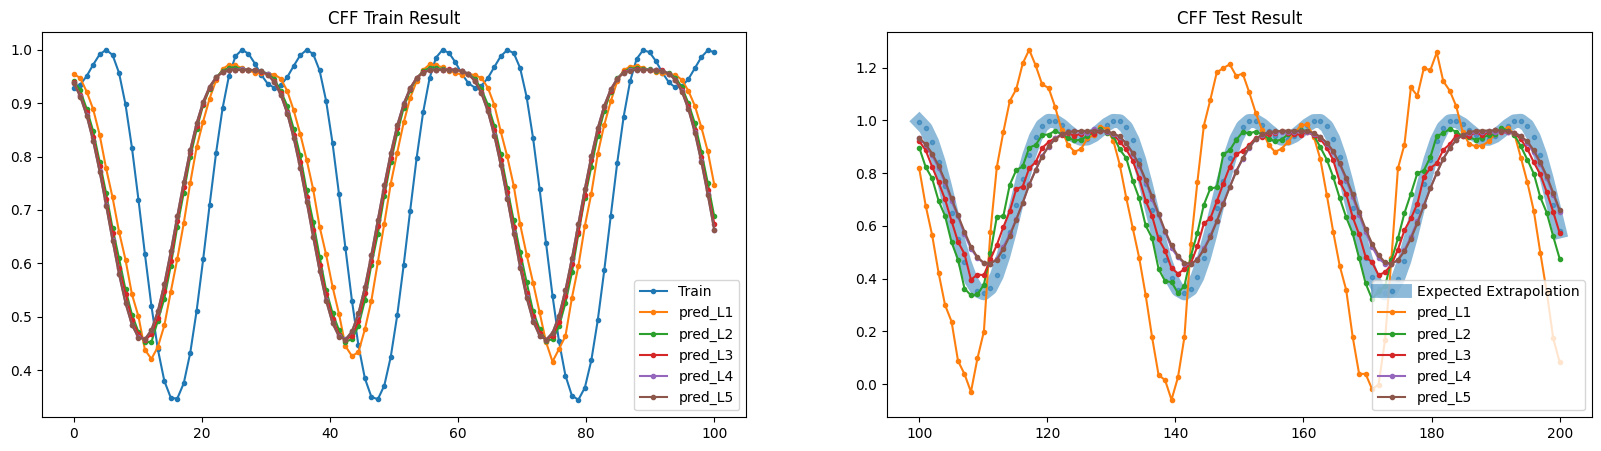

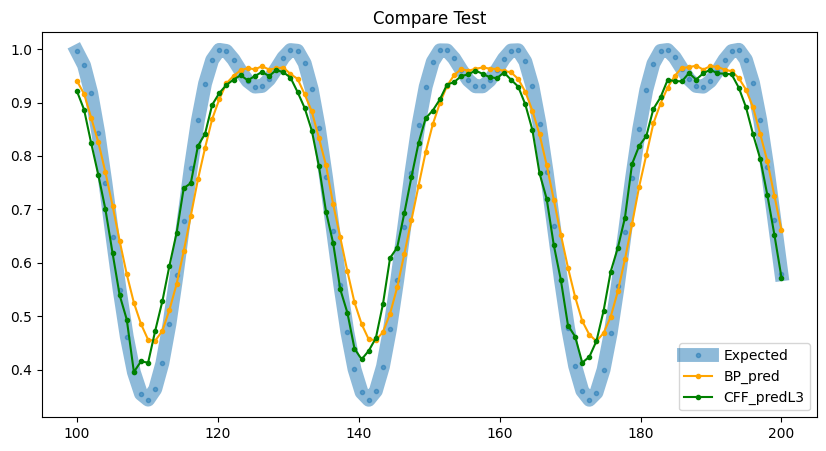

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 217.56it/s]


eval_mse: tr= 0.21348769962787628
eval_mse: te= 0.24525043368339539
eval_mse avg: te avg= 0.2531917989253998
-----------------CFF----------------------
eval_mse: tr= [0.7948480844497681, 0.13371680676937103, 0.14408646523952484, 0.14478524029254913, 0.1463664472103119, 0.14634831249713898]
eval_mse: te= [4.7192535400390625, 0.1305220127105713, 0.06205777823925018, 0.06429097056388855, 0.07198171317577362, 0.07204706966876984]  L 2 :  0.06205777823925018
avg_mse: te avg= [4.859077453613281, 0.21410371363162994, 0.25063517689704895, 0.2519557476043701, 0.2625439465045929, 0.26196861267089844]  L 1 :  0.21410371363162994


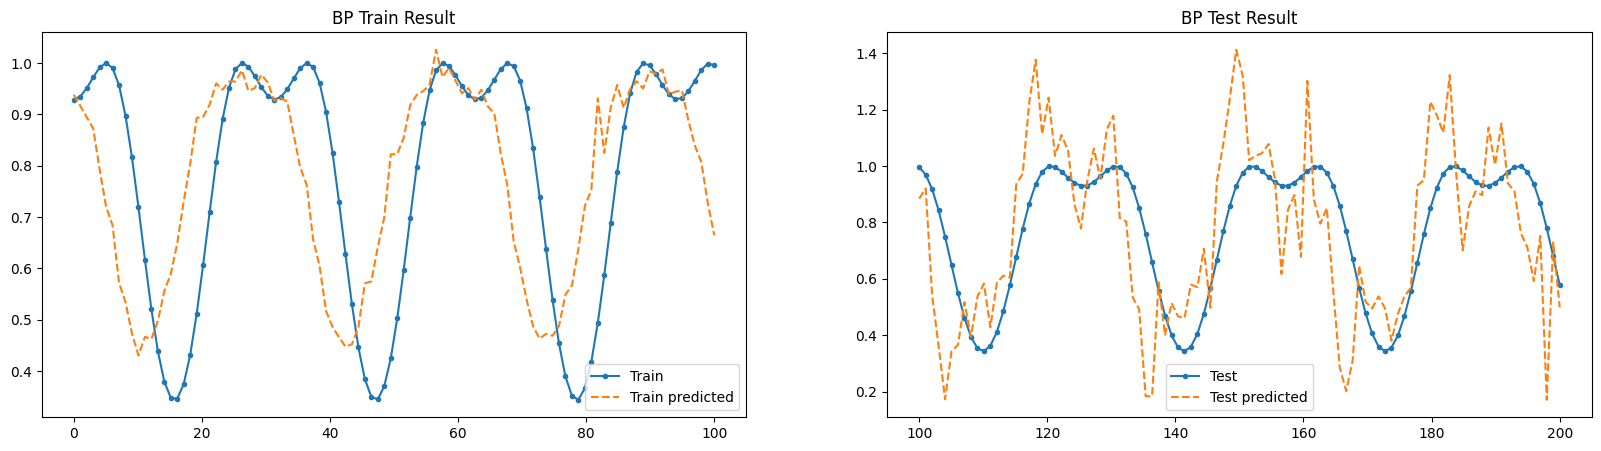

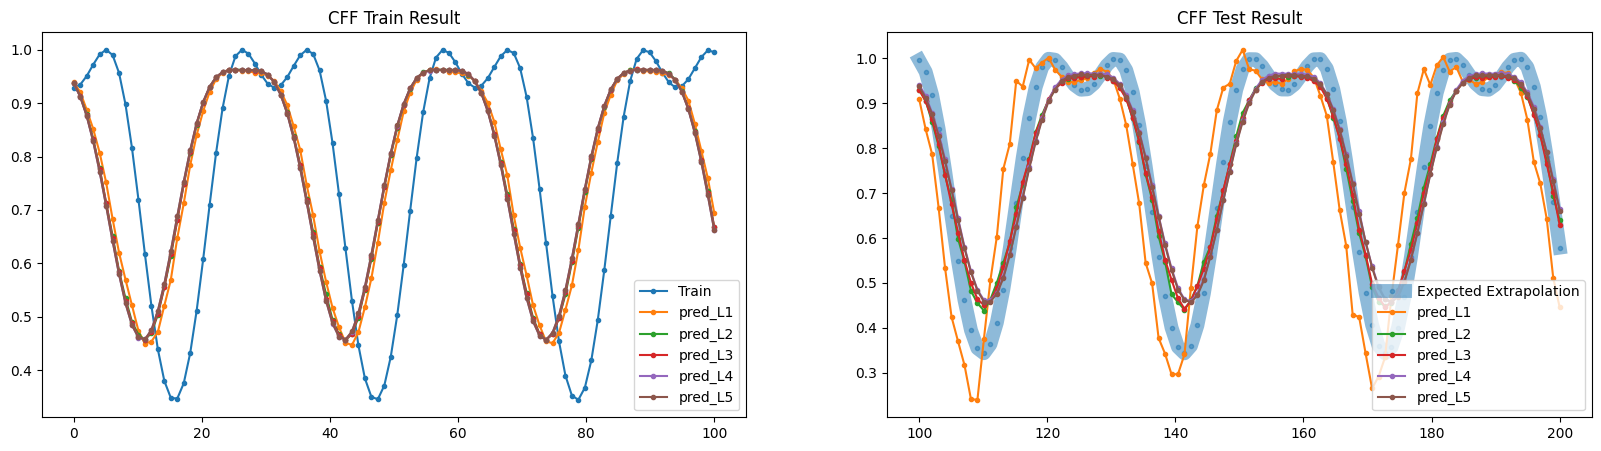

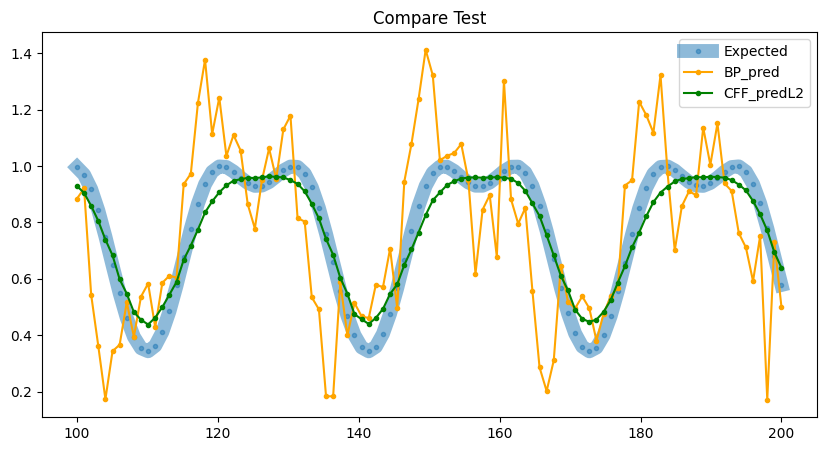

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 248.71it/s]


eval_mse: tr= 0.22291547060012817
eval_mse: te= 0.07219822704792023
eval_mse avg: te avg= 0.26157641410827637
-----------------CFF----------------------
eval_mse: tr= [1.6303085088729858, 0.1325119584798813, 0.14391569793224335, 0.1444123536348343, 0.14630120992660522, 0.146234393119812]
eval_mse: te= [6.163861274719238, 0.16907188296318054, 0.06259842962026596, 0.06270840018987656, 0.07170698791742325, 0.0707738995552063]  L 2 :  0.06259842962026596
avg_mse: te avg= [6.328812122344971, 0.21567095816135406, 0.24625733494758606, 0.2437649816274643, 0.26184558868408203, 0.2601928114891052]  L 1 :  0.21567095816135406


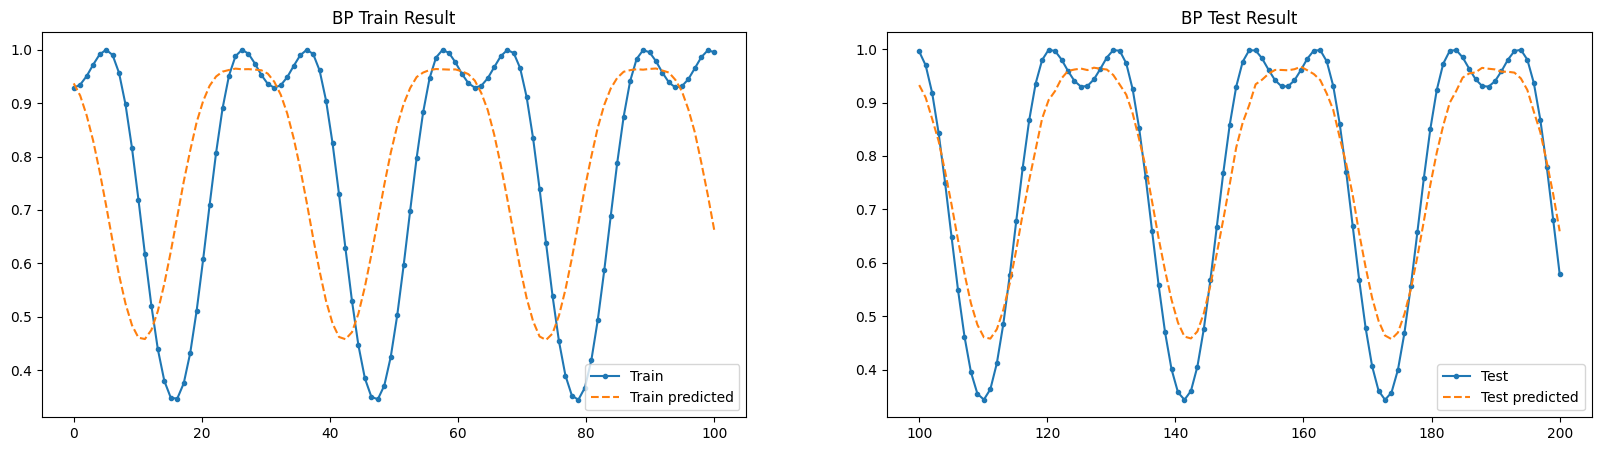

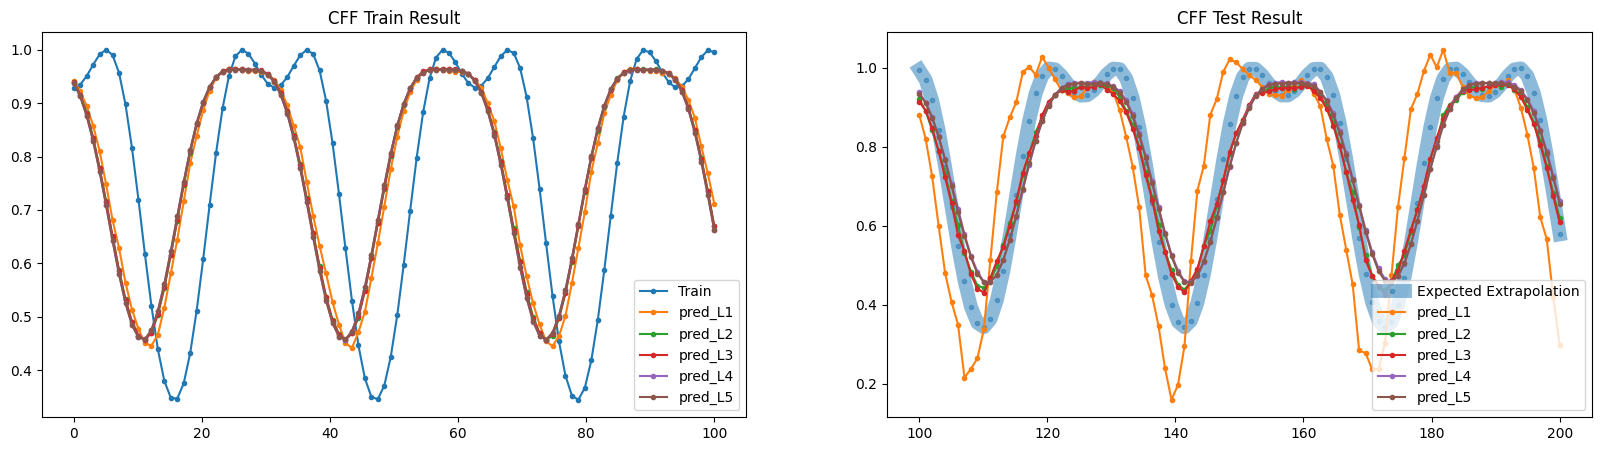

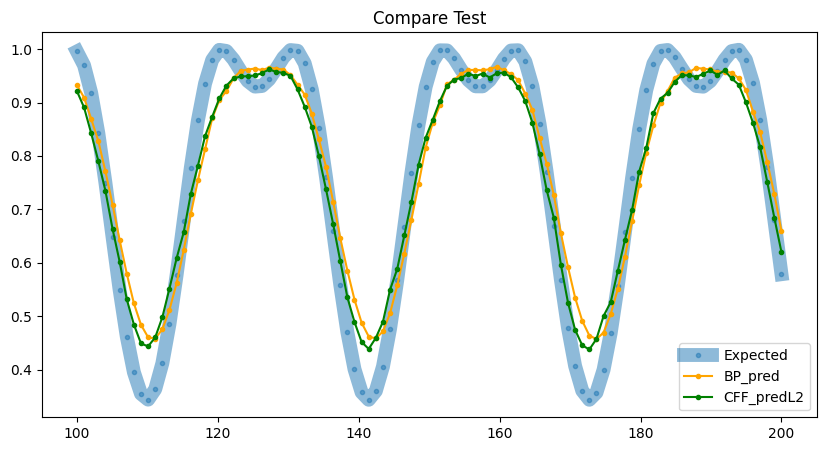

In [49]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.sin(0.8*np.cos(0.2*x)+20), do_plot=False)
for _ in range(3):
    get_results(cff_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)

In [63]:
to_rate([0.07136176526546478, 0.24525043368339539, 0.07219822704792023],
        [0.0627288967370987, 0.06205777823925018, 0.06259842962026596],
        range=0.7)

range 0.7
BP  [10.1945379  35.03577624 10.31403244] %
CFF [8.96127096 8.86539689 8.9426328 ] %
CFF better? (>0?) [ 1.23326693 26.17037935  1.37139963] %
--------------avg
BP avg 18.514782190322876 % BP_s avg nan
CFF avg 8.923100218886423 %
Avg, CFF better? (>0?) 9.591681971436453 % stable_better= nan


<ipython-input-35-4304e86423a8>:14: RuntimeWarning: Mean of empty slice.
  BeSA = BeS.mean()


## cos sin c

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 331.74it/s]


eval_mse: tr= 0.050662897527217865
eval_mse: te= 0.024726038798689842
eval_mse avg: te avg= 0.05307898297905922
-----------------CFF----------------------
eval_mse: tr= [1.802135944366455, 0.024412943050265312, 0.030337588861584663, 0.03014473058283329, 0.0312855988740921, 0.031424008309841156]
eval_mse: te= [4.360637187957764, 0.09717924147844315, 0.017534296959638596, 0.018256578594446182, 0.01702948845922947, 0.017563851550221443]  L 4 :  0.01702948845922947
avg_mse: te avg= [4.491699695587158, 0.09358198195695877, 0.047191280871629715, 0.04607196897268295, 0.05075901001691818, 0.05174069479107857]  L 3 :  0.04607196897268295


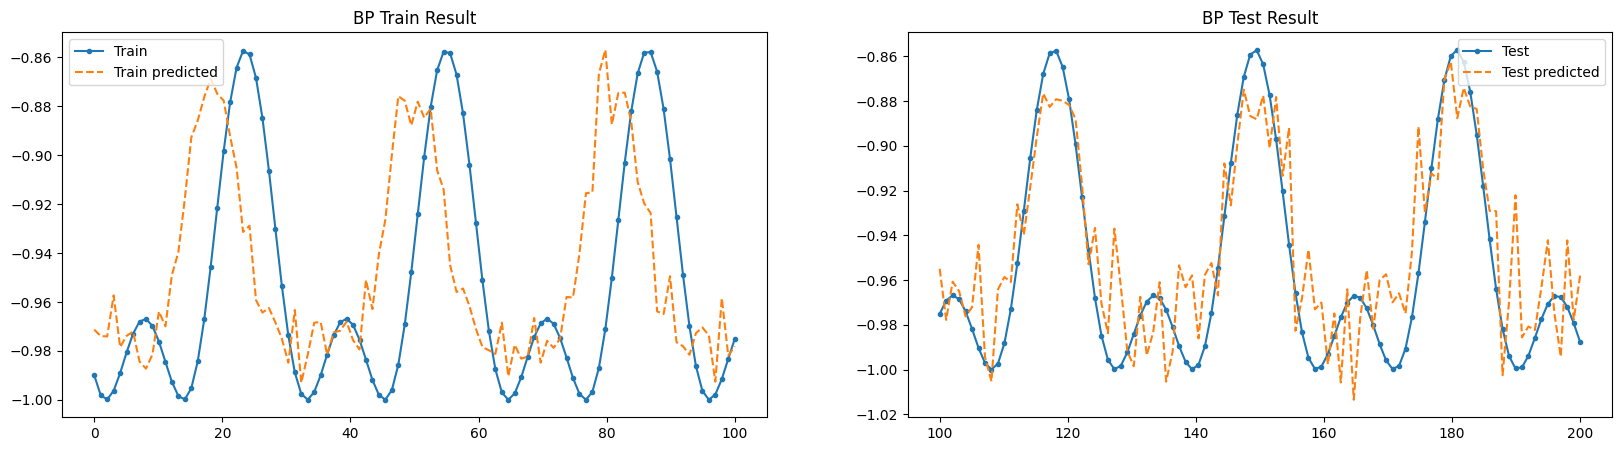

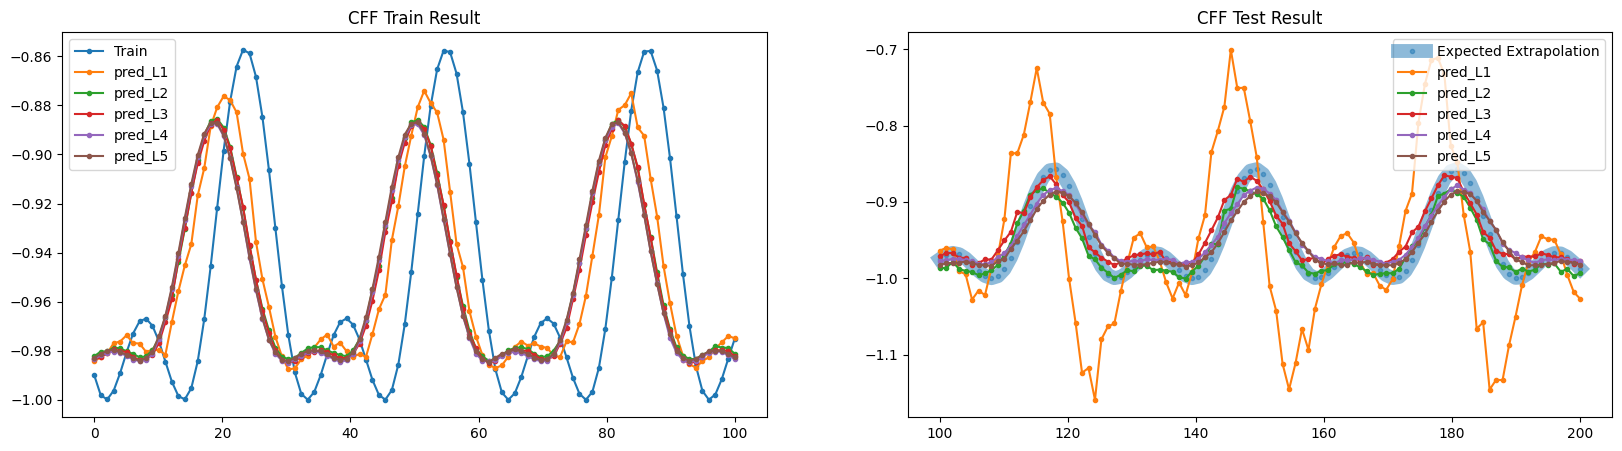

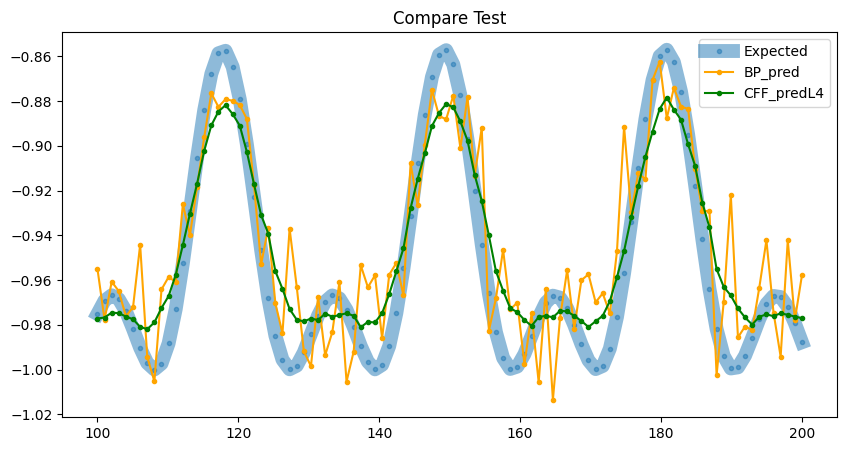

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 296.72it/s]


eval_mse: tr= 0.048427652567625046
eval_mse: te= 0.017604028806090355
eval_mse avg: te avg= 0.05330277234315872
-----------------CFF----------------------
eval_mse: tr= [1.3740531206130981, 0.020283909514546394, 0.02937927655875683, 0.02983434498310089, 0.03140748664736748, 0.031402263790369034]
eval_mse: te= [3.261119842529297, 0.1742483675479889, 0.03206489607691765, 0.022334052249789238, 0.02005423977971077, 0.017365122213959694]  L 5 :  0.017365122213959694
avg_mse: te avg= [3.3648037910461426, 0.16792966425418854, 0.04954544082283974, 0.0449337363243103, 0.05230269581079483, 0.051548443734645844]  L 3 :  0.0449337363243103


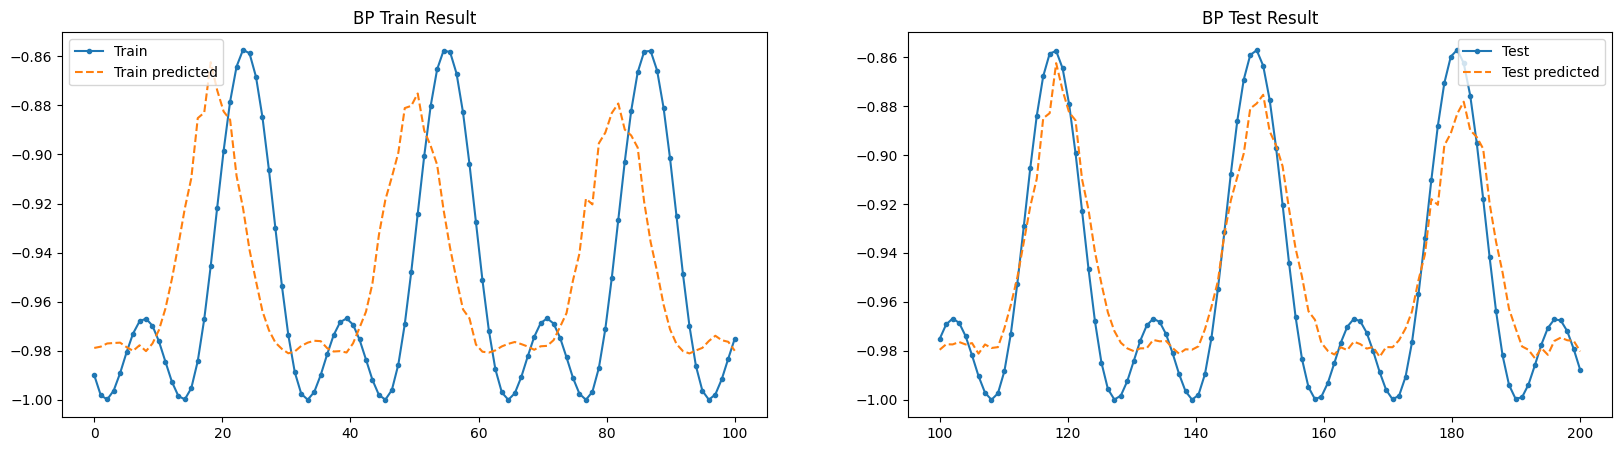

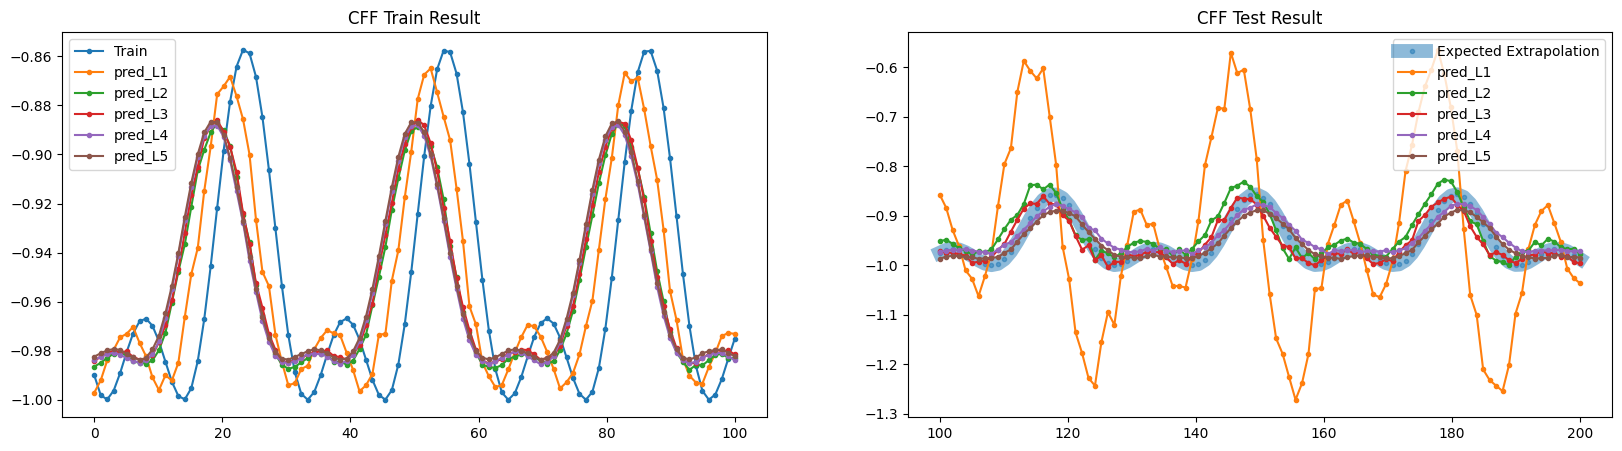

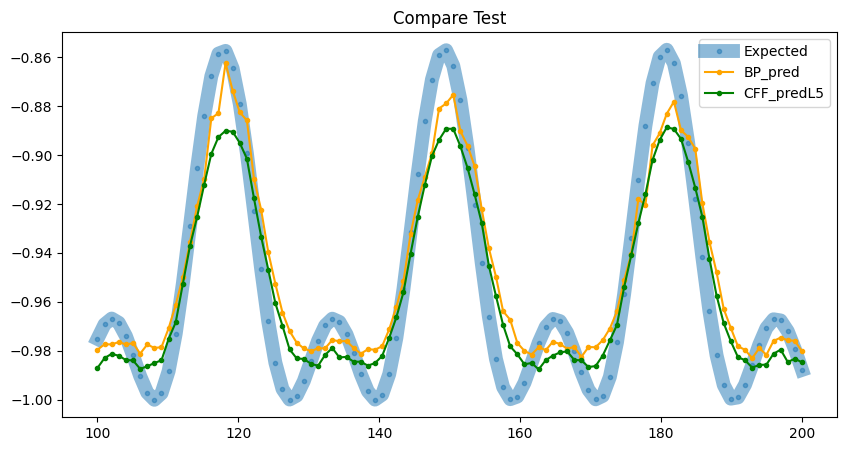

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 255.78it/s]


eval_mse: tr= 0.049488481134176254
eval_mse: te= 0.017208028584718704
eval_mse avg: te avg= 0.053225308656692505
-----------------CFF----------------------
eval_mse: tr= [1.1751387119293213, 0.02315838821232319, 0.030815575271844864, 0.030768906697630882, 0.031421124935150146, 0.03142688423395157]
eval_mse: te= [3.1052987575531006, 0.10618794709444046, 0.014822633005678654, 0.014560016803443432, 0.017481109127402306, 0.017446225509047508]  L 3 :  0.014560016803443432
avg_mse: te avg= [3.210817337036133, 0.102432981133461, 0.04890158399939537, 0.04836990684270859, 0.05185367539525032, 0.051853906363248825]  L 3 :  0.04836990684270859


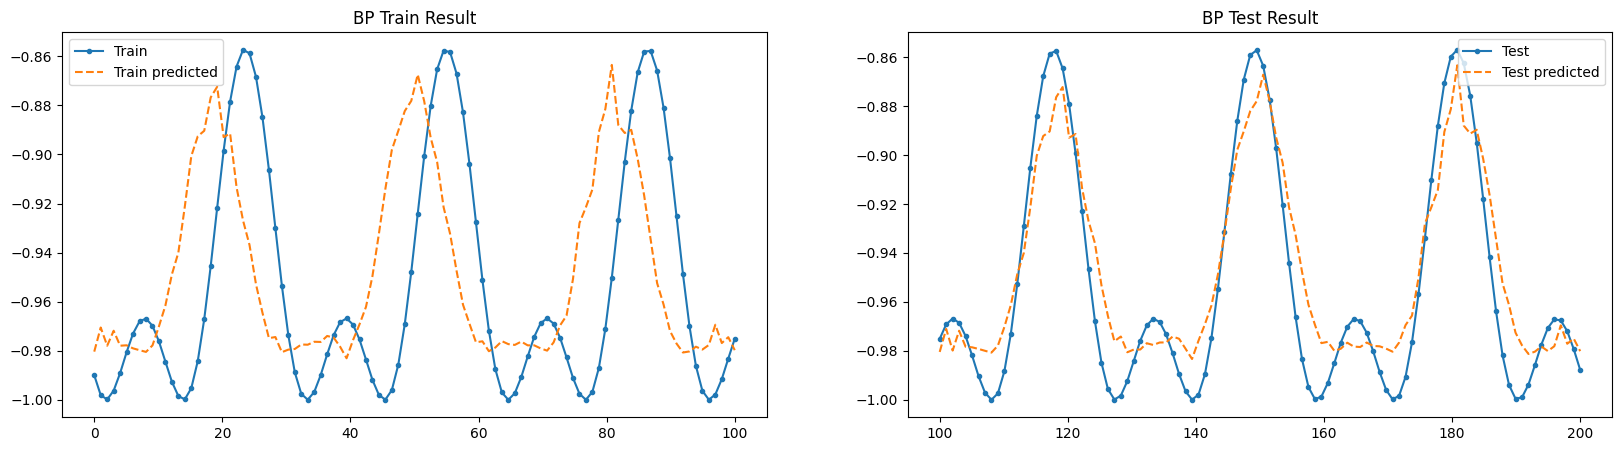

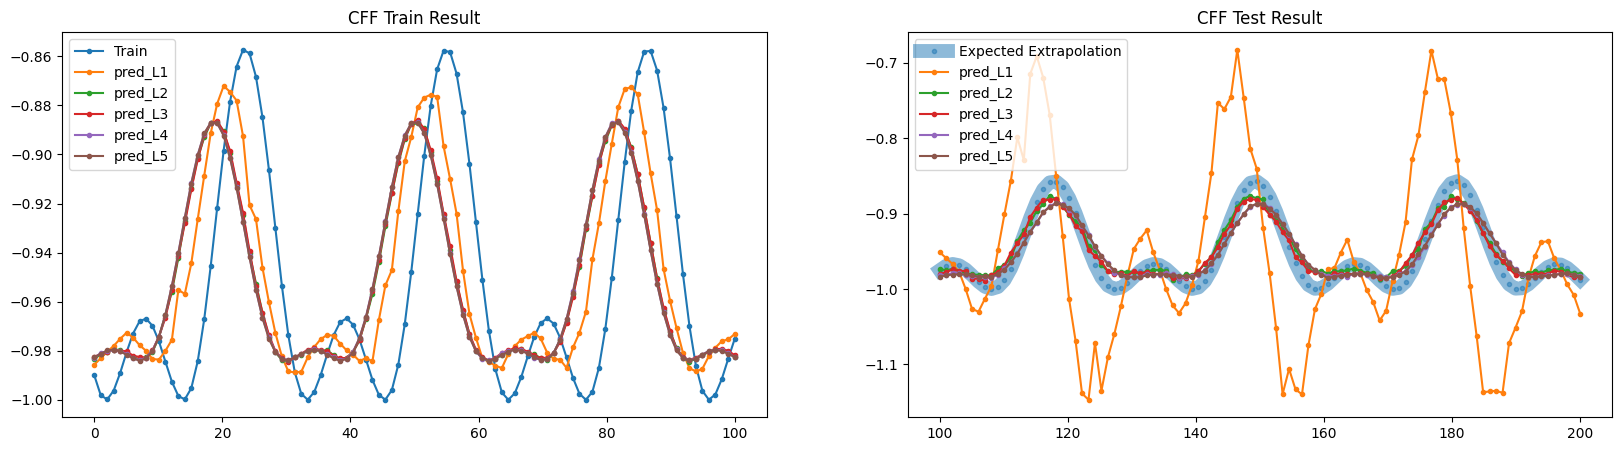

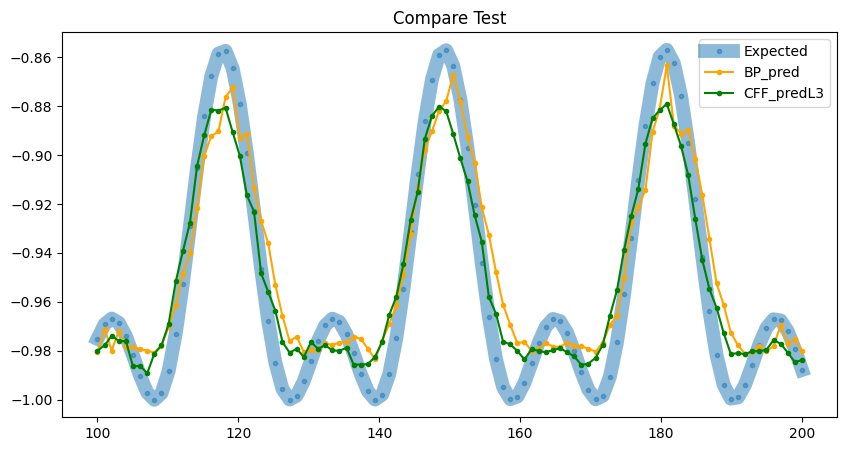

In [51]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.cos(0.4*np.sin(0.2*x)+3), do_plot=False)
for _ in range(3):
    get_results(cff_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)

In [64]:
to_rate([0.024726038798689842, 0.017604028806090355, 0.017208028584718704],
        [0.01702948845922947, 0.017365122213959694, 0.014560016803443432],
        range=0.15)

range 0.15
BP  [16.48402587 11.7360192  11.47201906] %
CFF [11.35299231 11.57674814  9.70667787] %
CFF better? (>0?) [5.13103356 0.15927106 1.76534119] %
--------------avg
BP avg 13.230688042110868 % BP_s avg nan
CFF avg 10.878806105918356 %
Avg, CFF better? (>0?) 2.3518819361925125 % stable_better= nan


<ipython-input-35-4304e86423a8>:14: RuntimeWarning: Mean of empty slice.
  BeSA = BeS.mean()
